# Анализ сайта «СберАвтоподписка»

## Постановка задачи

Компания «СберАвтоподписка» хочет увеличить эффективность сайта: улучшить пользовательский опыт, повысить конверсию, сделать рекламные кампании более результативными. Для этого вам предстоит создать модель, которая предсказывает вероятность того, что пользователь совершит целевое действие (оставит заявку, закажет звонок и пр.) на сайте.

Эта модель поможет:    

*   Оценивать эффективность каналов привлечения трафика;
*   Адаптировать рекламные кампании;
*   Улучшать UX сайта за счет анализа поведения пользователей.

## Описание данных

**GA Sessions**

Одна строка = один визит на сайт.

Описание атрибутов:

* session_id — ID визита;
* client_id — ID посетителя;
* visit_date — дата визита;
* visit_time — время визита;
* visit_number — порядковый номер визита клиента;
* utm_source — канал привлечения;
* utm_medium — тип привлечения;
* utm_campaign — рекламная кампания;
* utm_keyword — ключевое слово;
* device_category — тип устройства;
* device_os — ОС устройства;
* device_brand — марка устройства;
* device_model — модель устройства;
* device_screen_resolution — разрешение экрана;
* device_brand — марка устройства;
* device_model — модель устройства;
* device_screen_resolution — разрешение экрана;
* device_browser — браузер;
* geo_country — страна;
* geo_city — город.


**GA Hits**

Одна строка = одно событие в рамках одного визита на сайт.

Описание атрибутов:
* session_id — ID визита;
* hit_date — дата события;
* hit_time — время события;
* hit_number — порядковый номер события в рамках сессии;
* hit_type — тип события;
* hit_referer — источник события;
* hit_page_path — страница события;
* event_category — тип действия;
* event_action — действие;
* event_label — тег действия;
* event_value — значение результата действия.

## Подготовка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import json

from scipy import stats
from scipy.stats import chi2_contingency
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# # загружаем датасеты с гугл диска
# #!pip install --upgrade gdown
# !gdown 17PAkiniYx3Dff8YQJUsHoTeiUwl6k5qU
# !gdown 1Q_X8ZaH_3Ia90VxshY_yArI2zqZCmLky

In [3]:
# читаем датасет
df_sessions = pd.read_csv('ga_sessions.csv', low_memory=False)
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


Мы видим, что в датасете есть пропуски.

In [4]:
# определим размерность датасета
df_sessions.shape

(1860042, 18)

In [5]:
# выведем информацию о датасете
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


Датасет содержит 1 860 042 строк и 18 столбцов. Столбец с датами имеет тип object, мы будем преобразовывать его в datetime.

In [6]:
df_sessions['visit_datetime'] = pd.to_datetime(df_sessions['visit_date'] + ' ' + df_sessions['visit_time'])

Проверим данные на наличие полных дубликатов:

In [7]:
print('Количество дубликатов: {}'.format(df_sessions[df_sessions.duplicated()].shape[0]))

Количество дубликатов: 0


In [8]:
# посчитаем процент пропусков
(df_sessions.isnull().mean()*100).round()

session_id                   0.0
client_id                    0.0
visit_date                   0.0
visit_time                   0.0
visit_number                 0.0
utm_source                   0.0
utm_medium                   0.0
utm_campaign                12.0
utm_adcontent               18.0
utm_keyword                 58.0
device_category              0.0
device_os                   58.0
device_brand                20.0
device_model                99.0
device_screen_resolution     0.0
device_browser               0.0
geo_country                  0.0
geo_city                     0.0
visit_datetime               0.0
dtype: float64

Удаляем столбец *device_model* из-за высокого процента пропусков.

In [9]:
df_sessions.drop('device_model', axis=1, inplace=True)

Далее приступим к заполнению пропусков. Проанализируем столбцы *device_browser*, *device_brand*, и *device_os*.

In [10]:
# выведем список браузеров
df_sessions['device_browser'].unique()

array(['Chrome', 'Samsung Internet', 'Safari', 'YaBrowser',
       'Android Webview', 'Safari (in-app)', 'Opera', 'Firefox', 'Edge',
       'helloworld', 'Instagram 208.0.0.32.135 Android',
       'Instagram 209.0.0.21.119 Android', 'Android Runtime',
       'UC Browser', 'Mozilla Compatible Agent', '(not set)', 'Mozilla',
       'Opera Mini', 'Coc Coc', 'Instagram 213.0.0.29.120 Android',
       'Android', 'Instagram 216.1.0.21.137 Android', '[FBAN',
       'Internet Explorer', 'Puffin', 'MRCHROME', 'com.vk.vkclient',
       'Instagram 202.0.0.23.119', 'Android Browser', 'Maxthon',
       'Instagram 207.0.0.28.118', 'Instagram 216.0.0.12.135',
       'Instagram 199.1.0.34.119 Android', 'Instagram 192.0.0.37.119',
       'Amazon Silk', 'SeaMonkey', 'Instagram 194.0.0.36.172 Android',
       'Instagram 202.0.0.37.123 Android', 'MyApp', 'NetFront',
       'Instagram 201.0.0.23.111', 'Instagram 203.0.0.26.117',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 An

Мы видим похожие значения: 'Safari' и 'Safari (in-app)'. Приведем их к одному виду.

In [11]:
df_sessions['device_browser'] = df_sessions['device_browser'].replace('Safari (in-app)', 'Safari')

Выведем информацию об устройствах с пропущенным значением *device_brand*, использующих браузер Safari.

In [12]:
missing_count = df_sessions[
    (df_sessions['device_browser'].str.lower() == 'safari') & (df_sessions['device_brand'].isnull())
].shape[0]

print(f'Количество пропусков в столбце device_brand с браузером Safari: {missing_count}')

Количество пропусков в столбце device_brand с браузером Safari: 40955


Так как браузер Safari используется только на устройствах Apple, мы можем заполнить пропуски в *device_brand* значением 'Apple'.

In [13]:
# заполняем пропуски
df_sessions.loc[
    (df_sessions['device_browser'].str.lower() == 'safari') & (df_sessions['device_brand'].isnull()),
    'device_brand'
] = 'Apple'

Выведем информацию об устройствах Apple.

In [14]:
missing_count = df_sessions[
    (df_sessions['device_brand'].str.lower() == 'apple') & (df_sessions['device_os'].isnull())
].shape[0]

print(f'Количество пропусков в столбце device_os с устройством Apple: {missing_count}')

Количество пропусков в столбце device_os с устройством Apple: 371434


In [15]:
# выведем список ОС
df_sessions['device_os'].unique()

array(['Android', nan, 'iOS', 'Windows', 'Linux', 'Macintosh',
       '(not set)', 'Chrome OS', 'BlackBerry', 'Tizen', 'Firefox OS',
       'Samsung', 'Windows Phone', 'Nokia'], dtype=object)

In [16]:
# фильтрация строк по device_os == 'Macintosh'
mac_df = df_sessions[df_sessions['device_os'] == 'Macintosh']
print(mac_df['device_category'].value_counts())

device_category
desktop    24804
tablet        10
mobile        10
Name: count, dtype: int64


In [17]:
df_sessions['device_category'].unique()

array(['mobile', 'tablet', 'desktop'], dtype=object)

В случае с устройствами Apple мы можем однозначно идентифицировать ОС. Заполним пропуски значениями 'iOS' и 'Macintosh'.

In [18]:
# заполняем пропуски
df_sessions.loc[
    (df_sessions['device_os'].isnull()) &
    (df_sessions['device_brand'].str.lower() == 'apple') &
    (df_sessions['device_category'].isin(['mobile', 'tablet'])),
    'device_os'
] = 'iOS'

df_sessions.loc[
    (df_sessions['device_os'].isnull()) &
    (df_sessions['device_brand'].str.lower() == 'apple') &
    (df_sessions['device_category'] == 'desktop'),
    'device_os'
] = 'Macintosh'

Заполним оставшиеся пропуски значением 'unknown'.

In [19]:
# заполняем пропуски
cols_to_fill = ['utm_source','utm_campaign','utm_adcontent','utm_keyword','device_os','device_brand']
df_sessions[cols_to_fill] = df_sessions[cols_to_fill].fillna('unknown')

In [20]:
# проверяем, что все пропуски заполнены
df_sessions.isnull().sum()

session_id                  0
client_id                   0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
utm_keyword                 0
device_category             0
device_os                   0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
visit_datetime              0
dtype: int64

In [21]:
# читаем датасет
df_hits = pd.read_csv('ga_hits.csv')
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


Мы видим, что в датасете есть пропущенные значения.

In [22]:
# определим размерность датасета
df_hits.shape

(15726470, 11)

Датасет содержит 15 726 470 строк и 11 столбцов.

In [23]:
# выведем информацию о датасете
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


Проверим данные на наличие полных дубликатов:

In [24]:
print('Количество дубликатов: {}'.format(df_hits[df_hits.duplicated()].shape[0]))

Количество дубликатов: 0


In [25]:
# посчитаем процент пропусков
(df_hits.isnull().mean()*100).round()

session_id          0.0
hit_date            0.0
hit_time           58.0
hit_number          0.0
hit_type            0.0
hit_referer        40.0
hit_page_path       0.0
event_category      0.0
event_action        0.0
event_label        24.0
event_value       100.0
dtype: float64

Удаляем столбец *event_value*, так как в нём пропущены все значения, и *hit_time*, так как он содержит 58% пропущенных значений их невозможно корректно восстановить.

In [26]:
df_hits.drop(['hit_time', 'event_value'], axis=1, inplace=True)

Приступаем к заполнению пропусков. ... значением 'unknown'.

In [27]:
cols_to_fill = ['hit_referer','event_label']
df_hits[cols_to_fill] = df_hits[cols_to_fill].fillna('unknown')

In [28]:
df_hits.isnull().sum()

session_id        0
hit_date          0
hit_number        0
hit_type          0
hit_referer       0
hit_page_path     0
event_category    0
event_action      0
event_label       0
dtype: int64

Посчитаем количество пользовательских действий за сессию.

In [29]:
# вычисляем hit_count
hit_stats = df_hits.groupby('session_id').agg(
    hit_count = ('hit_number', 'max')
).reset_index()

# объединяем с df_sessions
df_merged = df_sessions.merge(hit_stats, on='session_id', how='inner')

df_merged.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_datetime,hit_count
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,2021-11-24 14:36:32,4
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,2021-11-14 08:21:30,3
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,2021-12-28 02:42:06,20
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,unknown,NOBKLgtuvqYWkXQHeYWM,unknown,mobile,unknown,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29 05:00:00,7
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,unknown,unknown,unknown,mobile,unknown,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29 05:00:00,3


Список целевых действий

In [30]:
target_actions_list = [    
    
   # заявка / обратный звонок:
    'sub_car_request_submit_click',
    'sub_callback_submit_click',
    'form_request_call_sent',
    'click_on_request_call',
    'phone_auth_success',
    'click_on_create_new_account_confirmation',
    'request_success',
    'user gave contacts during chat',
    'callback requested',
    'chat requested',
    'offline message sent',
    'mobile call',
    
  # чат с оператором:
    'click_on_start_chatting',
    'client initiate chat',
    'chat established',
    'proactive invitation accepted',
    'client answer on agent request',
    
  # успешные формы:
    'sub_submit_success',
    'greenday_sub_submit_success',
    'click_setelem_credit',
    'setelem_credit_form_button',
    'tinkoff_credit_form_button',
    'sravni_credit_form_button',
    'setelem_postzalog_retargeting_button',
    
  # намерение купить:
    'click_buy_auto',
    'click_auto_subscription',
    'click_sell_car',
    'click_credit',
    'click_pos_credit',
    'click_car_selection',
    'click_car_buyback',
    'success_ad_creation',
    
  # под вопросом:
    'go_to_offer',
    'open_offer',
    'sub_offer_click',
    'request',
    'click_free_car_selection',
    'click_on_credit_btn',
    'calculate',
    'sub_custom_question_submit_click',
    'sub_open_dialog_click',
    'click_on_support'
]

Добавим столбец 'target_action' со значениями 1 - если в сессии совершено хотя бы 1 целевое действие, и 0 - если целевых действий не совершалось.

In [31]:
df_hits['target_action'] = df_hits['event_action'].isin(target_actions_list).astype(int)
target_actions = df_hits.groupby('session_id')['target_action'].max().reset_index()
df_merged = df_merged.merge(target_actions, on='session_id', how='inner')
df_merged.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_datetime,hit_count,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,2021-11-24 14:36:32,4,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,2021-11-14 08:21:30,3,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,2021-12-28 02:42:06,20,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,unknown,NOBKLgtuvqYWkXQHeYWM,unknown,mobile,unknown,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29 05:00:00,7,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,unknown,unknown,unknown,mobile,unknown,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29 05:00:00,3,0


In [32]:
# выведем информацию о датасете
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 20 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 object        
 2   visit_date                object        
 3   visit_time                object        
 4   visit_number              int64         
 5   utm_source                object        
 6   utm_medium                object        
 7   utm_campaign              object        
 8   utm_adcontent             object        
 9   utm_keyword               object        
 10  device_category           object        
 11  device_os                 object        
 12  device_brand              object        
 13  device_screen_resolution  object        
 14  device_browser            object        
 15  geo_country               object        
 16  geo_city                  object        
 17  visit_da

Аргегируем данные по *client_id*.

In [33]:
# категориальные столбцы
categorical_cols = [
    'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword',
    'device_category', 'device_os', 'device_brand', 'device_screen_resolution',
    'device_browser', 'geo_country', 'geo_city'
]

# агрегируем категориальные признаки, используя моду
mode_agg = df_merged.groupby('client_id')[categorical_cols].agg(lambda x: x.mode().iloc[0])

# числовые агрегаты
numeric_agg = df_merged.groupby('client_id').agg(
    session_count=('session_id', 'nunique'),
    max_visit_number=('visit_number', 'max'),
    avg_hit_count=('hit_count', 'mean'),
    total_target_actions=('target_action', 'max')    
)

# агрегаты по датам
visit_stats = df_merged.groupby('client_id').agg(
    first_visit=('visit_datetime', 'min'),
    last_visit=('visit_datetime', 'max'),
    active_days=('visit_datetime', lambda x: x.dt.date.nunique()),
    avg_days_between=('visit_datetime', lambda x: (x.max() - x.min()) / max(1, len(x) - 1))
)

# объединяем все в один датафрейм
df_client_agg = pd.concat([numeric_agg, mode_agg, visit_stats], axis=1).reset_index()

df_client_agg.head()

,client_id,session_count,max_visit_number,avg_hit_count,total_target_actions,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,first_visit,last_visit,active_days,avg_days_between
0,1000000719.1634385152,1,1,11.00,0,BHcvLfOaCWvWTykYqHVe,cpc,unknown,unknown,unknown,...,unknown,Meizu,360x720,YaBrowser,Russia,Moscow,2021-10-16 14:00:00,2021-10-16 14:00:00,1,0 days 00:00:00
1,10000026.1621927845,2,2,28.50,0,aXQzDWsJuGXeBXexNHjc,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,...,iOS,Apple,375x667,Safari,Russia,Moscow,2021-05-25 10:00:00,2021-05-25 11:00:00,1,0 days 01:00:00
2,1000002812.1632654122,4,4,27.25,0,BHcvLfOaCWvWTykYqHVe,cpc,unknown,unknown,unknown,...,unknown,Huawei,360x760,YaBrowser,Russia,Saint Petersburg,2021-09-26 14:00:00,2021-10-06 08:00:00,3,3 days 06:00:00
3,1000004514.1631015304,1,1,3.00,0,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,unknown,...,unknown,unknown,2560x1400,Chrome,Russia,Moscow,2021-09-07 14:00:00,2021-09-07 14:00:00,1,0 days 00:00:00
4,1000005466.1623263709,1,1,4.00,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,...,unknown,Samsung,384x854,Samsung Internet,Russia,Surgut,2021-06-09 21:00:00,2021-06-09 21:00:00,1,0 days 00:00:00


In [34]:
df_client_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320704 entries, 0 to 1320703
Data columns (total 21 columns):
 #   Column                    Non-Null Count    Dtype          
---  ------                    --------------    -----          
 0   client_id                 1320704 non-null  object         
 1   session_count             1320704 non-null  int64          
 2   max_visit_number          1320704 non-null  int64          
 3   avg_hit_count             1320704 non-null  float64        
 4   total_target_actions      1320704 non-null  int64          
 5   utm_source                1320704 non-null  object         
 6   utm_medium                1320704 non-null  object         
 7   utm_campaign              1320704 non-null  object         
 8   utm_adcontent             1320704 non-null  object         
 9   utm_keyword               1320704 non-null  object         
 10  device_category           1320704 non-null  object         
 11  device_os                 1320704 non

## Разведочный анализ данных (EDA)

In [35]:
# выведем статистику по числовым признакам
print(df_client_agg.describe().round(2))

       session_count  max_visit_number  avg_hit_count  total_target_actions  \
count     1320704.00        1320704.00     1320704.00            1320704.00   
mean            1.31              1.37          13.99                  0.07   
min             1.00              1.00           1.00                  0.00   
25%             1.00              1.00           3.00                  0.00   
50%             1.00              1.00           8.00                  0.00   
75%             1.00              1.00          18.00                  0.00   
max           449.00            564.00         500.00                  1.00   
std             1.77              2.49          17.49                  0.25   

                         first_visit                     last_visit  \
count                        1320704                        1320704   
mean   2021-09-28 04:27:10.193105152  2021-09-29 23:34:03.134083840   
min              2021-05-19 10:00:00            2021-05-19 10:00:00   
25% 

**Проанализируем результаты:**

1. *Поведение большинства пользователей*
- Среднее количество сессий — 1.31, медиана — 1: почти все пользователи совершают одну сессию, то есть не возвращаются на сайт.
- Максимальное количество визитов пользователя: медиана — 1, среднее — 1.37. Пользователи крайне редко совершают повторные визиты.

2. *Активность и вовлеченность*
- Среднее количество хитов на пользователя: медиана 8, среднее 13.99, но максимум — 500. Есть отдельные пользователи с очень высокой активностью, но большая часть — с малой.
- Целевые действия: 75% пользователей вообще не совершают целевых действий. Среднее значение — 0.07. Конверсия крайне низкая, большая часть пользователей не выполняет целевые действия.

3. *Временная активность*
- Первый и последний визиты: разброс по датам от мая до конца декабря 2021 года.
- Количество активных дней: медиана 1, среднее 1.14. Большинство пользователей активны только в один день.
- Среднее время между сессиями: медиана и 75% = 0 подтверждает, что пользователи не возвращаются.

4. *Дисперсия*
- Присутствуют редкие супер-активные пользователи, сильно отличающиеся от основной массы: session_count и max_visit_number имеют высокие максимумы (до 449 и 564), но средние значения сильно занижены из-за подавляющего большинства пользователей с одним визитом.

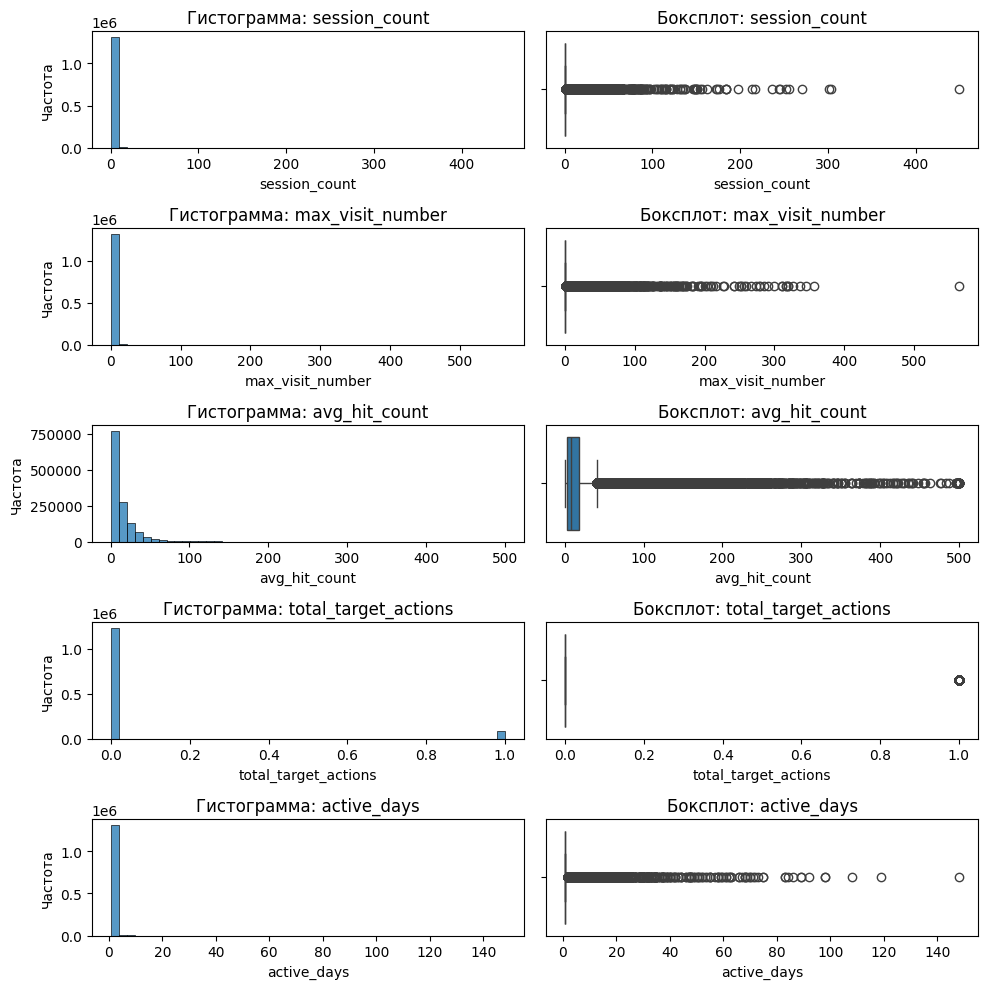

In [36]:
# визуализируем распределение числовых признаков

numeric_cols = [
    'session_count',
    'max_visit_number',
    'avg_hit_count',
    'total_target_actions',
    'active_days',
]

plt.figure(figsize=(10, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 2, 2*i-1)
    sns.histplot(df_client_agg[col].dropna(), bins=50, kde=False)
    plt.title(f'Гистограмма: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')

    plt.subplot(len(numeric_cols), 2, 2*i)
    sns.boxplot(x=df_client_agg[col].dropna())
    plt.title(f'Боксплот: {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

Все числовые признаки имеют выраженную правую скошенность, с концентрацией значений у минимальных значений и редкими крупными выбросами. Распределение не является нормальным.

In [37]:
# рассчитаем конверсию
total_sessions = len(df_client_agg)
converted_sessions = (df_client_agg['total_target_actions'] > 0).sum()

conversion_rate = converted_sessions / total_sessions
print(f"Конверсия: {conversion_rate:.2%}")

Конверсия: 6.68%


Посмотрим, различается ли уровень конверсии в зависимости от канала привлечения клиента, кампании, типа устройства и т.д.

In [38]:
# группируем по каналу привлечения
conversion_by_source = df_client_agg.groupby('utm_source').agg(
    users=('client_id', 'nunique'),
    conversions=('total_target_actions', 'sum')
).sort_values(by='users', ascending=False).head(10)

conversion_by_source['conversion_rate'] = round(
    100 * conversion_by_source['conversions'] / conversion_by_source['users'], 2
)

# группируем по каналу привлечения
conversion_by_medium = df_client_agg.groupby('utm_medium').agg(
    users=('client_id', 'nunique'),
    conversions=('total_target_actions', 'sum')
).sort_values(by='users', ascending=False).head(10)

conversion_by_medium['conversion_rate'] = round(
    100 * conversion_by_medium['conversions'] / conversion_by_medium['users'], 2
)

# группируем по кампании
conversion_by_campaign = df_client_agg.groupby('utm_campaign').agg(
    users=('client_id', 'nunique'),
    conversions=('total_target_actions', 'sum')
).sort_values(by='users', ascending=False).head(10)

conversion_by_campaign['conversion_rate'] = round(
    100 * conversion_by_campaign['conversions'] / conversion_by_campaign['users'], 2
)

# группируем по креативу
conversion_by_adcontent = df_client_agg.groupby('utm_adcontent').agg(
    users=('client_id', 'nunique'),
    conversions=('total_target_actions', 'sum')
).sort_values(by='users', ascending=False).head(10)

conversion_by_adcontent['conversion_rate'] = round(
    100 * conversion_by_adcontent['conversions'] / conversion_by_adcontent['users'], 2
)

# группируем по промокоду
conversion_by_keyword = df_client_agg.groupby('utm_keyword').agg(
    users=('client_id', 'nunique'),
    conversions=('total_target_actions', 'sum')
).sort_values(by='users', ascending=False).head(10)

conversion_by_keyword['conversion_rate'] = round(
    100 * conversion_by_keyword['conversions'] / conversion_by_keyword['users'], 2
)

# группируем по типу устройства
conversion_by_device = df_client_agg.groupby('device_category').agg(
    users=('client_id', 'nunique'),
    conversions=('total_target_actions', 'sum')
)

conversion_by_device['conversion_rate'] = round(
    100 * conversion_by_device['conversions'] / conversion_by_device['users'], 2
)

# группируем по бренду устройства
conversion_by_brand = df_client_agg.groupby('device_brand').agg(
    users=('client_id', 'nunique'),
    conversions=('total_target_actions', 'sum')
)

conversion_by_brand['conversion_rate'] = round(
    100 * conversion_by_brand['conversions'] / conversion_by_brand['users'], 2
)

# группируем по городам
conversion_city = df_client_agg.groupby('geo_city').agg(
    users=('client_id', 'nunique'),
    conversions=('total_target_actions', 'sum')
).sort_values(by='users', ascending=False).head(10)

conversion_city['conversion_rate'] = round(100 * conversion_city['conversions'] / conversion_city['users'], 2)

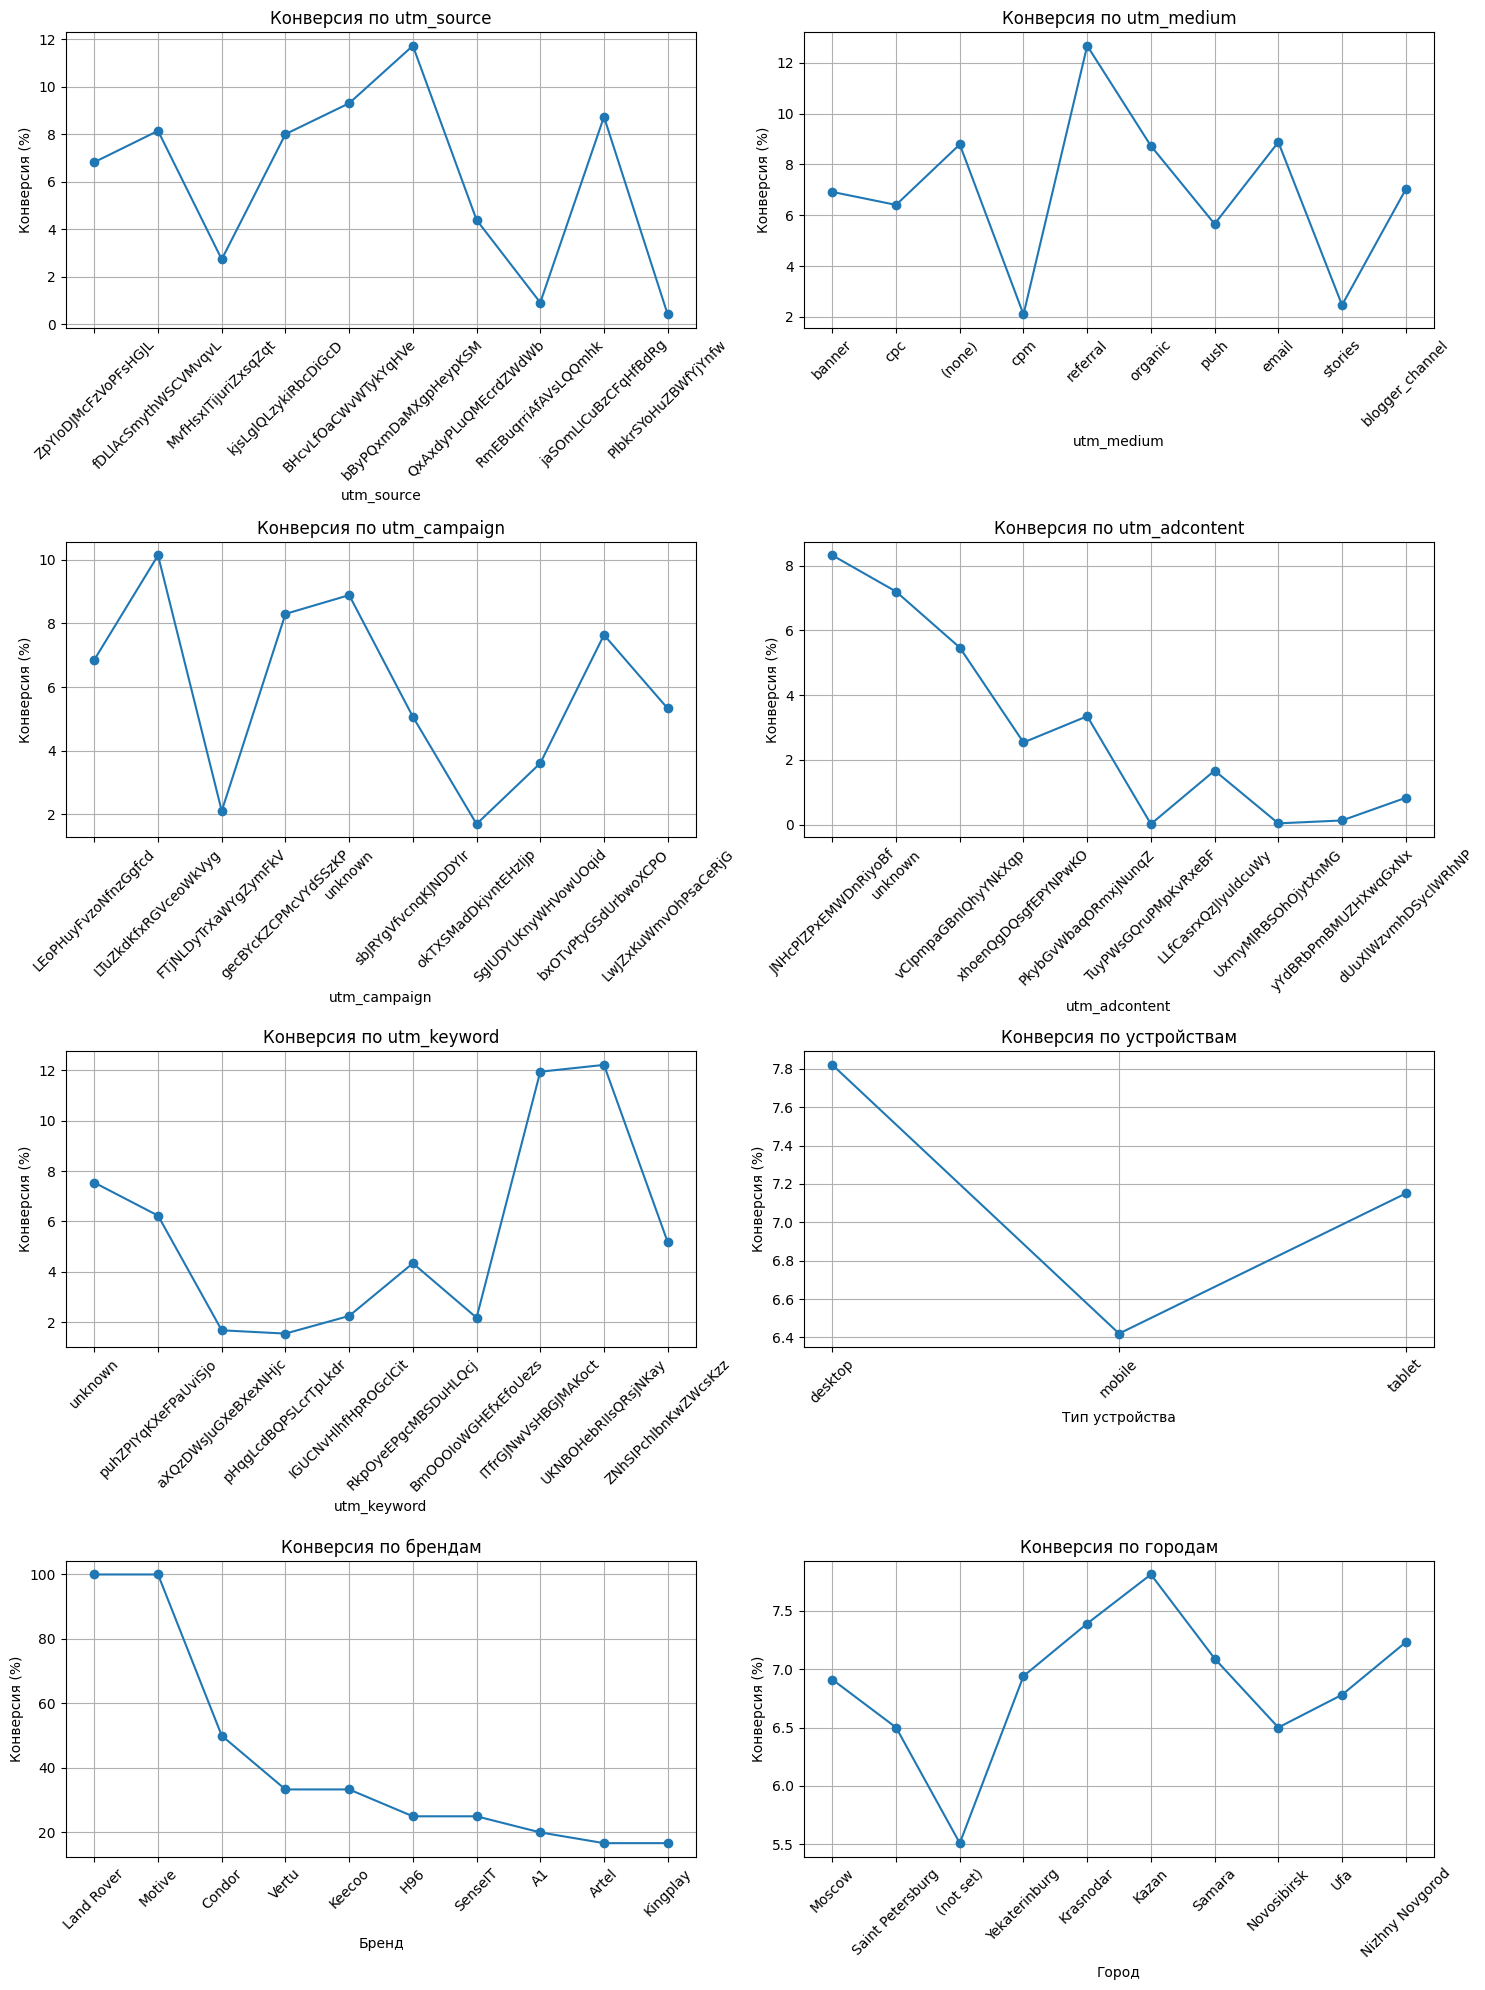

In [39]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))  # 1 строка, 2 столбца
axes = axes.flatten()

axes[0].plot(conversion_by_source.index, conversion_by_source['conversion_rate'], marker='o')
axes[0].set_title('Конверсия по utm_source')
axes[0].set_xlabel('utm_source')
axes[0].set_ylabel('Конверсия (%)')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(conversion_by_medium.index, conversion_by_medium['conversion_rate'], marker='o')
axes[1].set_title('Конверсия по utm_medium')
axes[1].set_xlabel('utm_medium')
axes[1].set_ylabel('Конверсия (%)')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

axes[2].plot(conversion_by_campaign.index, conversion_by_campaign['conversion_rate'], marker='o')
axes[2].set_title('Конверсия по utm_campaign')
axes[2].set_xlabel('utm_campaign')
axes[2].set_ylabel('Конверсия (%)')
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)

axes[3].plot(conversion_by_adcontent.index, conversion_by_adcontent['conversion_rate'], marker='o')
axes[3].set_title('Конверсия по utm_adcontent')
axes[3].set_xlabel('utm_adcontent')
axes[3].set_ylabel('Конверсия (%)')
axes[3].grid(True)
axes[3].tick_params(axis='x', rotation=45)

axes[4].plot(conversion_by_keyword.index, conversion_by_keyword['conversion_rate'], marker='o')
axes[4].set_title('Конверсия по utm_keyword')
axes[4].set_xlabel('utm_keyword')
axes[4].set_ylabel('Конверсия (%)')
axes[4].grid(True)
axes[4].tick_params(axis='x', rotation=45)

axes[5].plot(conversion_by_device.index, conversion_by_device['conversion_rate'], marker='o')
axes[5].set_title('Конверсия по устройствам')
axes[5].set_xlabel('Тип устройства')
axes[5].set_ylabel('Конверсия (%)')
axes[5].grid(True)
axes[5].tick_params(axis='x', rotation=45)

top10 = conversion_by_brand.sort_values(by='conversion_rate', ascending=False).head(10)
axes[6].plot(top10.index, top10['conversion_rate'], marker='o')
axes[6].set_title('Конверсия по брендам')
axes[6].set_xlabel('Бренд')
axes[6].set_ylabel('Конверсия (%)')
axes[6].grid(True)
axes[6].tick_params(axis='x', rotation=45)

axes[7].plot(conversion_city.index, conversion_city['conversion_rate'], marker='o')
axes[7].set_title('Конверсия по городам')
axes[7].set_xlabel('Город')
axes[7].set_ylabel('Конверсия (%)')
axes[7].grid(True)
axes[7].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Мы видим, что для различных utm-метрик процент конверсии отличается. Мобильный трафик доминирует, но при этом desktop эффективнее конвертирует. Качество трафика сильно зависит от источника и канала - лучше фокусироваться на источниках и каналах с высокой конверсией. Прямой и органический трафик, а также email и referral каналы являются самыми результативные. Самая высокая конверсия наблюдается в Казани и Краснодаре.

Посмотрим на статистику посещений сайта за исследуемый временной период.

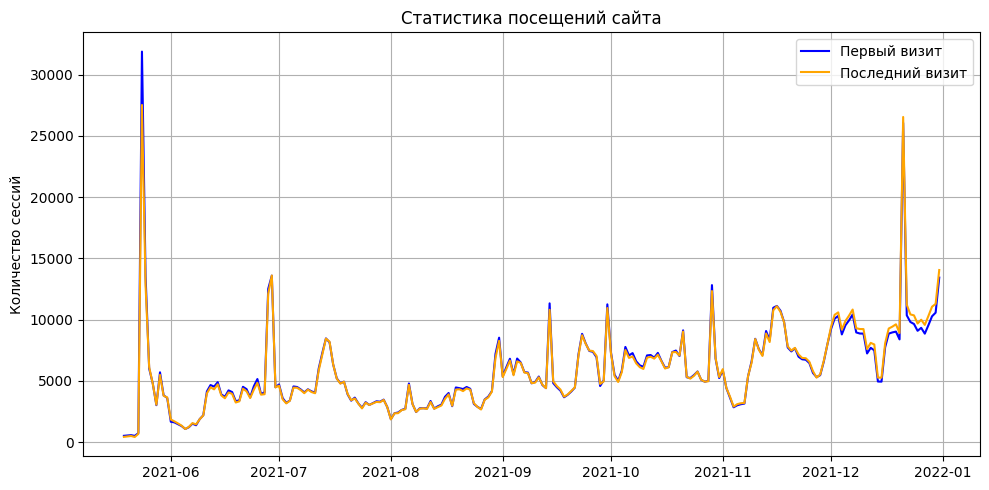

In [40]:
# группировка по дате первого визита
first_visits = df_client_agg.groupby(df_client_agg['first_visit'].dt.date)['client_id'].nunique()

# группировка по дате последнего визита
last_visits = df_client_agg.groupby(df_client_agg['last_visit'].dt.date)['client_id'].nunique()

# построение графика
plt.figure(figsize=(10, 5))
plt.plot(first_visits.index, first_visits.values, label='Первый визит', color='blue')
plt.plot(last_visits.index, last_visits.values, label='Последний визит', color='orange')
plt.title('Статистика посещений сайта')
plt.ylabel('Количество сессий')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Добавим в датафрейм временных метрик, которые выделим из столбца *first_visit*.

In [41]:
df_client_agg['month'] = df_client_agg['first_visit'].dt.month
df_client_agg['weekday'] = df_client_agg['first_visit'].dt.dayofweek  # 0 = понедельник
df_client_agg['hour'] = df_client_agg['first_visit'].dt.hour

In [42]:
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'утро'
    elif 12 <= hour < 17:
        return 'день'
    elif 17 <= hour < 22:
        return 'вечер'
    else:
        return 'ночь'

df_client_agg['time_of_day'] = df_client_agg['hour'].apply(get_time_of_day)

In [43]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

df_client_agg['season'] = df_client_agg['month'].apply(get_season)

Произведем типизацию данных, выделим категориальные признаки:

In [44]:
# приведение типов
num_cols = ['session_count','max_visit_number','active_days']
for col in num_cols:
    df_client_agg[col] = df_client_agg[col].astype(float)

# категориальные данные
cat_cols = [
    'utm_medium', 'device_category', 'device_os', 'device_browser', 'total_target_actions',
    'month', 'weekday', 'hour', 'time_of_day', 'season'
]
for col in cat_cols:
    df_client_agg[col] = df_client_agg[col].astype('category')

In [45]:
# выведем статистику по категориальным признакам
print(df_client_agg.describe(include=['object', 'category']))

                 client_id  total_target_actions            utm_source  \
count              1320704               1320704               1320704   
unique             1320704                     2                   239   
top     9999784.1634619321                     0  ZpYIoDJMcFzVoPFsHGJL   
freq                     1               1232419                490664   

       utm_medium          utm_campaign         utm_adcontent utm_keyword  \
count     1320704               1320704               1320704     1320704   
unique         51                   377                   259        1137   
top        banner  LEoPHuyFvzoNfnzGgfcd  JNHcPlZPxEMWDnRiyoBf     unknown   
freq       466332                291934                717956      747794   

       device_category device_os device_brand device_screen_resolution  \
count          1320704   1320704      1320704                  1320704   
unique               3        14          201                     4885   
top             mobil

**Проанализируем результаты:**

1. *Каналы трафика (UTM-метки)*
- Всего 239 уникальных источников, но самый частый занимает около 37% трафика - трафик сильно сконцентрирован на нескольких источниках.
- Основной канал привлечения — баннерная реклама (466,332 раз).
- 377 кампаний, но один топовый встречается 291,934 раз (~22%).
- 259 объявлений, но одно испоьлзуется более чем в 50% случаев - кампания неравномерно загружена, есть риск зависимости от узкой группы.
- Промокоды со значением 'unknown' составляют 50% от общего количества - плохая передача ключевых слов, либо некачественная настройка UTM.

3. *Устройства и браузеры*
- Мобильный трафик преобладает (80.8%), адаптивность критична.
- Почти 37% записей с неизвестной ОС - проблема сбора данных. Всего 14 ОС, но unknown — топ.
- По брендам устройств лидирует Apple, с них заходит около 30% пользователей.
- По разрешению экрана всего 4,885 вариантов, 414x896 - наиболее частый.
- Самый часто используемый браузер - Chrome (используется в 55.7% случаев), при разработке и тестировании логичнее ориентироваться на него.

4. *География*
- Почти 97% трафика из России. Предполагаем, что оставшиеся 3% тоже из России, но через VPN.
- Около 41% трафика приходится на Москву, что означает сильное региональное смещение спроса.
  
5. *Временная активность*
- Самый активный сезон - осень.
- Декабрь - пиковый месяц. Это может быть связано с сезонной активностью, маркетинговыми акциями и т.д. Всего в анализе участвует 8 месяцев.
- Трафик преимущественно дневной. Пиковый день - вторник, пиковый час - 14. 

In [46]:
# визуализируем полученные результаты

# выведем список месяцев
df_client_agg['month'].unique()

[10, 5, 9, 6, 12, 8, 11, 7]
Categories (8, int32): [5, 6, 7, 8, 9, 10, 11, 12]

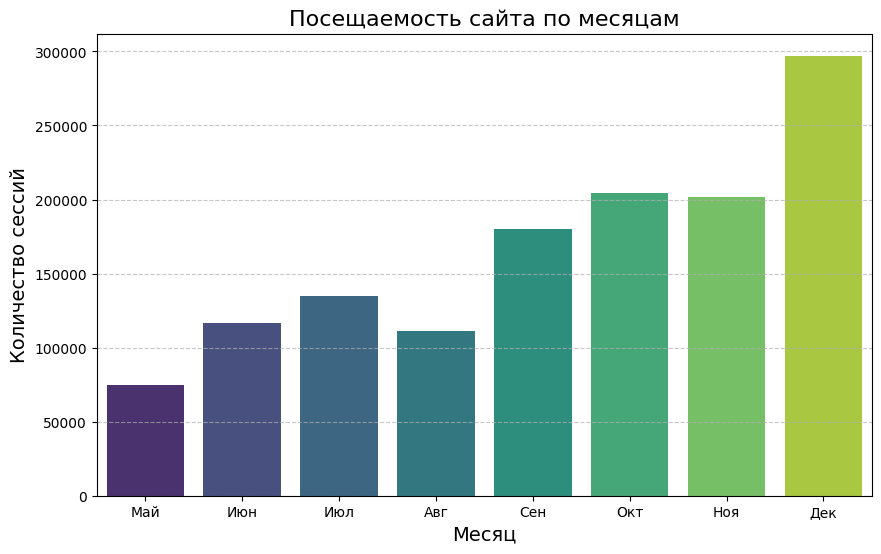

In [47]:
# группировка по месяцам
monthly_avg = df_client_agg.groupby('month', observed=False)['session_count'].count()

# построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, hue=monthly_avg.index, palette='viridis', legend=False)

# настройка графика
plt.title("Посещаемость сайта по месяцам", fontsize=16)
plt.xlabel("Месяц", fontsize=14)
plt.ylabel("Количество сессий", fontsize=14)
plt.xticks(ticks=range(8), labels=["Май", "Июн", "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Количество пользоватей с каждым сезоном увеличивается. Пиковый месяц - декабрь.

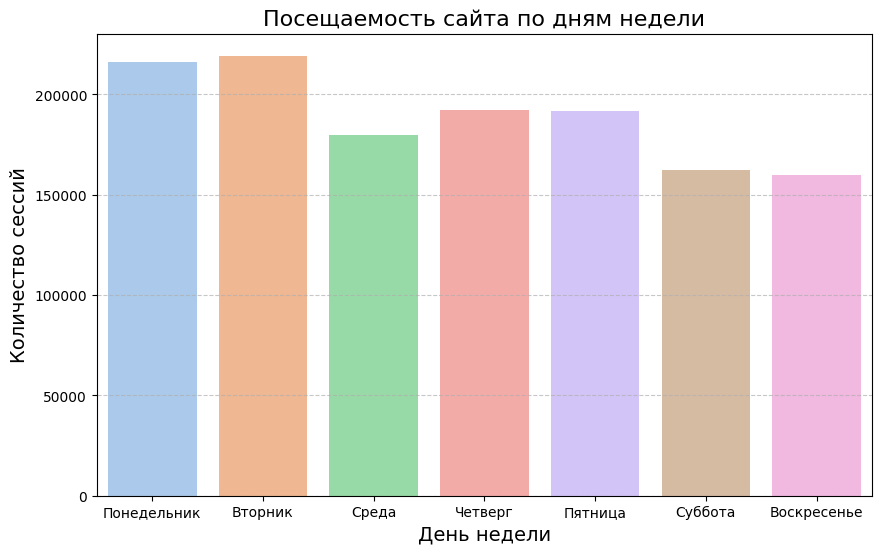

In [48]:
# Опционально: для текста вместо чисел (например, "Понедельник", "Вторник")
days_mapping = {
    0: "Понедельник", 1: "Вторник", 2: "Среда", 3: "Четверг",
    4: "Пятница", 5: "Суббота", 6: "Воскресенье"
}
df_client_agg['weekday'] = df_client_agg['weekday'].map(days_mapping)

# Группировка по дням недели
weekly_avg = df_client_agg.groupby('weekday', observed=False)['session_count'].count().reindex([
    "Понедельник", "Вторник", "Среда", "Четверг",
    "Пятница", "Суббота", "Воскресенье"
])

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x=weekly_avg.index, y=weekly_avg.values, hue=weekly_avg.index, palette='pastel', legend=False)

# Настройка графика
plt.title("Посещаемость сайта по дням недели", fontsize=16)
plt.xlabel("День недели", fontsize=14)
plt.ylabel("Количество сессий", fontsize=14)
plt.xticks(rotation=0)  # Поворот подписей оси X для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Самые активные дни - понедельник и вторник.

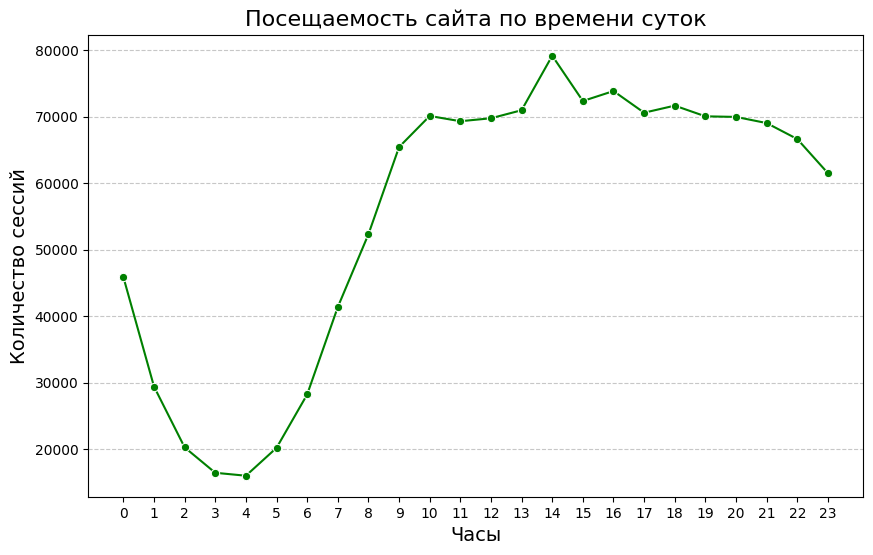

In [49]:
# группировка по часам
hourly_avg = df_client_agg.groupby('hour', observed=False)['session_count'].count()

# построение графика
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o', color='green', legend=False)

# настройка графика
plt.title("Посещаемость сайта по времени суток", fontsize=16)
plt.xlabel("Часы", fontsize=14)
plt.ylabel("Количество сессий", fontsize=14)
plt.xticks(ticks=range(0, 24))  # отображение всех часов
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Пользователи более активны в дневное время суток.

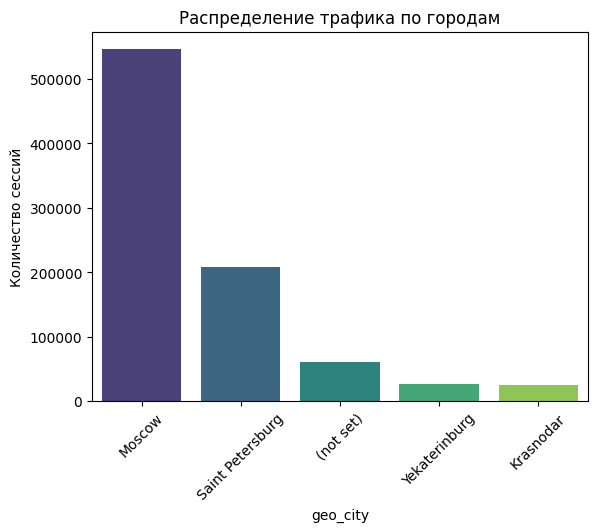

In [50]:
# выбираем топ-10 городов по трафику
city_tr_top10 = df_client_agg['geo_city'].value_counts().head()

# построение графика
#plt.figure(figsize=(20, 5))
sns.barplot(x=city_tr_top10.index, y=city_tr_top10.values, hue=city_tr_top10.index, palette='viridis', legend=False)

# добавляем подписи
plt.title('Распределение трафика по городам')
plt.ylabel('Количество сессий')
plt.tick_params(axis='x', rotation=45)

plt.show()

Большая часть трафика сосредоточена в Москве.

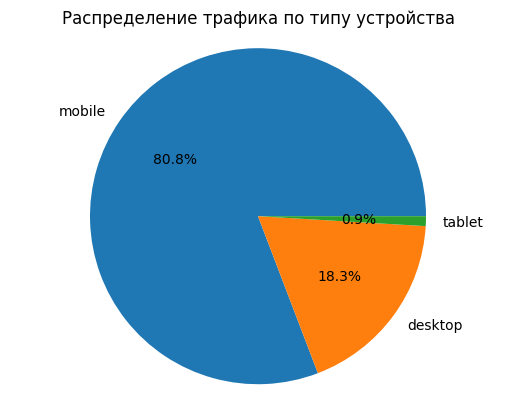

In [51]:
# строим диаграмму
category_counts = df_client_agg['device_category'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Распределение трафика по типу устройства')

plt.show()

Большая часть трафика идет со смартфонов.

Визуализируем статистику по распределению трафика по основным каналам привлечения клиентов:

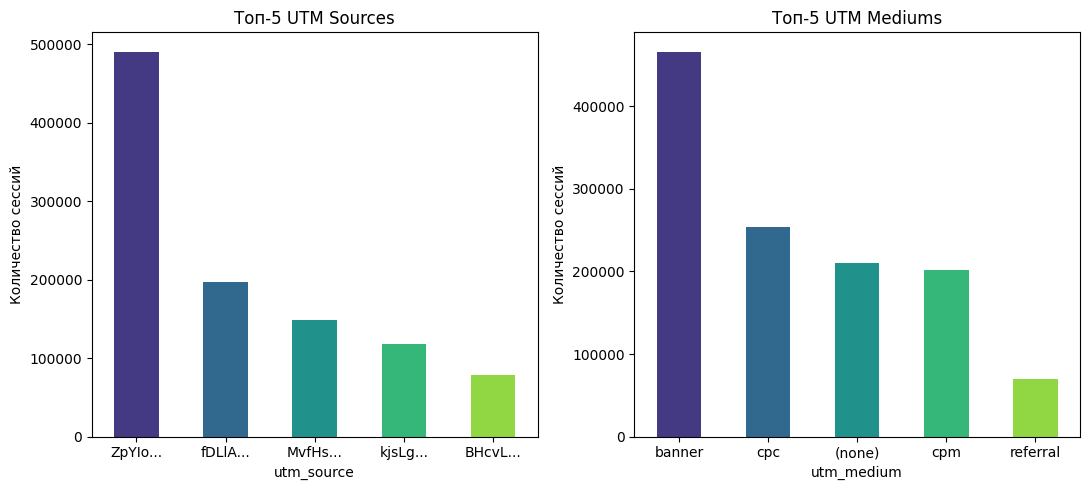

In [52]:
colors = sns.color_palette("viridis", 5)

# 1 строка, 2 столбца
fig, axes = plt.subplots(1, 2, figsize=(11, 5)) 

# топ-5 utm_source
utm_source_counts = df_client_agg['utm_source'].value_counts().head()
short_labels_1 = [label[:5] + '...' if len(label) > 15 else label for label in utm_source_counts.index]
utm_source_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Топ-5 UTM Sources')
axes[0].set_ylabel('Количество сессий')
axes[0].set_xticklabels(short_labels_1, rotation=0)

# топ-5 utm_medium
utm_medium_counts = df_client_agg['utm_medium'].value_counts().head()
utm_medium_counts.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Топ-5 UTM Mediums')
axes[1].set_ylabel('Количество сессий')
axes[1].set_xticklabels(utm_medium_counts.index, rotation=0)

# чтобы графики не налезали друг на друга
plt.tight_layout() 
plt.show()

In [53]:
# построим тепловую карту корреляции
correlation_matrix = df_client_agg.corr(numeric_only=True)

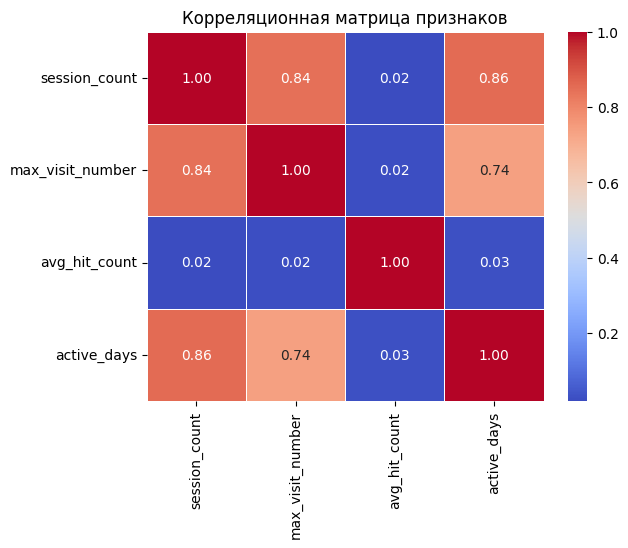

In [54]:
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица признаков')
plt.show()

Тесные связи, наблюдаемые на тепловой карте, ожидаемы.

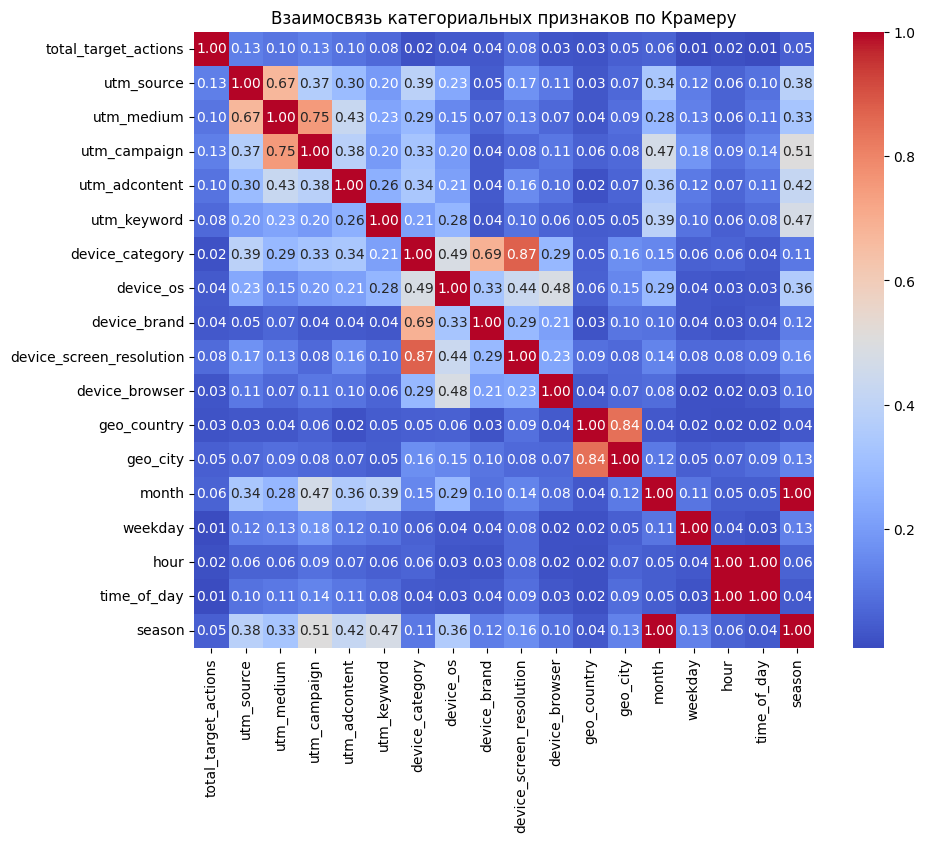

In [55]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# выбираем категориальные признаки
cat_columns = ['total_target_actions','utm_source','utm_medium','utm_campaign','utm_adcontent','utm_keyword',
               'device_category','device_os','device_brand','device_screen_resolution',
               'device_browser','geo_country','geo_city',
               'month','weekday','hour','time_of_day','season']

# строим матрицу Cramér’s V
cramer_matrix = pd.DataFrame(index=cat_columns, columns=cat_columns)

for col1 in cat_columns:
    for col2 in cat_columns:
        cramer_matrix.loc[col1, col2] = cramers_v(df_client_agg[col1], df_client_agg[col2])

cramer_matrix = cramer_matrix.astype(float)

# визуализируем
plt.figure(figsize=(10,8))
sns.heatmap(cramer_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Взаимосвязь категориальных признаков по Крамеру")
plt.show()

**Проанализируем результаты:**

- *UTM-метки* (source, medium, campaign, adcontent) тесно связаны — это ожидаемо, но есть избыточная взаимосвязь, что может ограничивать гибкость маркетинга.
- *Устройства* (brand, os, category) логично взаимосвязаны.

- *Целевые действия* (total_target_actions) не зависят от источников, устройств и времени напрямую.

- *Временные признаки* (month, season, time_of_day) почти не влияют на целевые действия, но влияют на кампании, следовательно, важно учитывать сезонность в маркетинговом планировании.

**Выводы по результатам EDA:**

Сайт не удерживает пользователей: 75% посещают его один раз и не возвращаются.

Существуют аномально активные пользователи, но это единичные случаи.

Трафик преимущественно мобильный, дневной, из России (особенно из Москвы).

Большинство пользователей не совершают целевых действий — нужна работа с конверсией.

Основные рекламные кампании и источники сильно перегружены — стоит диверсифицировать.

Данные по ОС и ключевым словам часто неполные или некорректные, возможно, стоит улучшить трекинг/аналитику.

Временные пики — день, вторник, декабрь — могут использоваться для оптимизации рекламной активности.

## Подготовка данных к моделированию

In [56]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
%matplotlib inline

In [57]:
df_sessions.columns

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
       'visit_datetime'],
      dtype='object')

In [58]:
df_t = df_client_agg[['total_target_actions', 'max_visit_number', 'utm_source', 'utm_medium', 'utm_campaign', 
                      'utm_adcontent', 'utm_keyword', 'device_category', 'device_os', 'device_brand', 
                      'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city', 'month', 'weekday', 
                      'hour', 'time_of_day', 'season']]

In [59]:
#df_client_agg.to_csv('df_client_agg.csv', index=False)

In [60]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320704 entries, 0 to 1320703
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype   
---  ------                    --------------    -----   
 0   total_target_actions      1320704 non-null  category
 1   max_visit_number          1320704 non-null  float64 
 2   utm_source                1320704 non-null  object  
 3   utm_medium                1320704 non-null  category
 4   utm_campaign              1320704 non-null  object  
 5   utm_adcontent             1320704 non-null  object  
 6   utm_keyword               1320704 non-null  object  
 7   device_category           1320704 non-null  category
 8   device_os                 1320704 non-null  category
 9   device_brand              1320704 non-null  object  
 10  device_screen_resolution  1320704 non-null  object  
 11  device_browser            1320704 non-null  category
 12  geo_country               1320704 non-null  object  
 13  geo_city    

In [61]:
mask = df_t['total_target_actions'] == 1

In [62]:
df_t.rename(columns={'max_visit_number': 'visit_number'}, inplace=True)

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\3905105644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.rename(columns={'max_visit_number': 'visit_number'}, inplace=True)


In [63]:
df_t[mask]['visit_number'].value_counts()[:10]

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\3219341829.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  df_t[mask]['visit_number'].value_counts()[:10]


visit_number
1.0     52888
2.0     15936
3.0      6508
4.0      3689
5.0      2178
6.0      1470
7.0      1050
8.0       782
9.0       576
10.0      442
Name: count, dtype: int64

In [64]:
df_t[mask]['utm_source'].value_counts()

utm_source
ZpYIoDJMcFzVoPFsHGJL    33535
fDLlAcSmythWSCVMvqvL    16095
kjsLglQLzykiRbcDiGcD     9442
bByPQxmDaMXgpHeypKSM     7434
BHcvLfOaCWvWTykYqHVe     7318
MvfHsxITijuriZxsqZqt     4080
aXQzDWsJuGXeBXexNHjc     2547
jaSOmLICuBzCFqHfBdRg     1901
QxAxdyPLuQMEcrdZWdWb     1763
ISrKoXQCxqqYvAZICvjs      529
hTjLvqNxGggkGnxSCaTm      467
nSReTmyFtbSjlPrTKoaX      332
IZEXUFLARCUMynmHNBGo      258
vFcAhRxLfOWKhvxjELkx      255
RmEBuqrriAfAVsLQQmhk      227
KgicpPxiEQfzPlPwQZJq      168
oZCzWSykfixnjMPDNjSU      150
iNFgfQPqHPBuvGCYtrQE      139
DnEUulZAecfGPvdtZBYS      123
BKeImrJuRDZcHiSSTdzm      110
eLzNJHzPelJpEyBwMrKo      106
PlbkrSYoHuZBWfYjYnfw       84
YlsczTIyBSwTLNtuDkCd       78
gVRrcxiDQubJiljoTbGm       76
FTAuYVNoYYxgvKMpKSLW       66
HFaOtpcChAlcMuxEAlpu       63
WEXkMlsnJodrzBgKJBpG       61
geDcueAOghDzHkGMmdOq       60
qVXuCoVQtPxcUkAXiXBa       56
dyicZQGoeASogoSafjEh       56
XiUifkjKLLnomcDRhswp       49
GmILPdZyuAVJCPsUBHeN       45
ZHCJROlbqnkXTqIuVxnm       42

In [65]:
# Получаем топ значений
top_sources = df_t[mask]['utm_source'].value_counts().head(25).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['utm_source'] = df_t['utm_source'].apply(lambda x: x if x in top_sources else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\3890583736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['utm_source'] = df_t['utm_source'].apply(lambda x: x if x in top_sources else 'other')


In [66]:
df_t[mask]['utm_medium'].value_counts()

utm_medium
banner               32288
(none)               18521
cpc                  16252
referral              8801
cpm                   4238
organic               2411
email                 1941
push                  1383
blogger_channel        449
smartbanner            283
cpv                    270
stories                242
post                   227
tg                     219
smm                    207
blogger_stories        119
cpa                    114
outlook                 74
clicks                  71
app                     62
(not set)               49
blogger_header          17
info_text               14
landing                 12
sms                      8
partner                  5
CPM                      2
link                     2
static                   1
medium                   1
yandex_cpc               1
fb_smm                   1
Sbol_catalog             0
article                  0
catalogue                0
cbaafe                   0
promo_sber       

In [67]:
# Получаем топ значений
top_medium = df_t[mask]['utm_medium'].value_counts().head(25).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['utm_medium'] = df_t['utm_medium'].apply(lambda x: x if x in top_medium else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\2207604157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['utm_medium'] = df_t['utm_medium'].apply(lambda x: x if x in top_medium else 'other')


In [68]:
df_t[mask]['utm_campaign'].value_counts()

utm_campaign
LTuZkdKfxRGVceoWkVyg    28292
LEoPHuyFvzoNfnzGgfcd    20039
gecBYcKZCPMcVYdSSzKP     9463
unknown                  8898
FTjNLDyTrXaWYgZymFkV     4362
XHNUiSKKGTEpSAlaVMFQ     1169
bxOTvPtyGSdUrbwoXCPO      990
sbJRYgVfvcnqKJNDDYIr      901
YCKgTzTDywjcWyQudGch      882
LwJZxKuWmvOhPsaCeRjG      652
nSReTmyFtbSjlPrTKoaX      627
RoDitORHdzGfGhNCyEMy      594
bJJuEXRheRIxXEaYIXqM      543
zxoiLxhuSIFrCeTLQVWZ      534
SgIUDYUKnyWHVowUOqid      495
jvsVVQVKRfBIqBDBuCkq      423
MXqmDyetMTICSSitTjWV      405
JwYIveaHVpeeRZloQCfF      348
eimRuUrNhZLAYcwRrNXu      345
hkvDVxqLOzGjGaoNiNzN      325
jqlUOdZBNZYfInQVcZlS      286
okTXSMadDkjvntEHzIjp      281
PXQWdUxeUoXfoKzTBGpY      269
YDIkQmcjRkpdxGbLLtNN      268
ESphyUeLTPINiYALHWrO      267
QEejXfOCtOMFLZqIPApp      262
WiILFRDQbcHDHNvHzGpX      253
QdLfySaGXolfTBSNVfHn      241
TmThBvoCcwkCZZUWACYq      240
IKQsApKuPmZqqmhieEgf      231
UvuMsOSDBWQGOIbDbXfV      231
wpmatvDuiMutnvmNVPJo      230
HEimDfYZIzuQXDZAAcEW      2

In [69]:
# Получаем топ значений
top_campaign = df_t[mask]['utm_campaign'].value_counts().head(25).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['utm_campaign'] = df_t['utm_campaign'].apply(lambda x: x if x in top_campaign else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\2450533990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['utm_campaign'] = df_t['utm_campaign'].apply(lambda x: x if x in top_campaign else 'other')


In [70]:
df_t[mask]['utm_adcontent'].value_counts()

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    59761
unknown                 12816
vCIpmpaGBnIQhyYNkXqp     8643
xhoenQgDQsgfEPYNPwKO     2223
PkybGvWbaqORmxjNunqZ     1666
nNqUcgFgcqQbTVSvgaHr      428
XSkXBCPfnJjvxbfeewtd      275
LLfCasrxQzJIyuldcuWy      274
guyNoEvzgofQvvwExGOq      267
SOkCdPxfUcZUzzOdgGES      227
AdeErYgVTbRcAWtHrMHq      117
SAVVWaMghGnnvPOqMOIt      108
sYzBROYhjSDbFZCpzGyf      106
qhEmhjPXvwgEHdBikgEQ       99
WAeycgIqKXoOMXPzDUDX       82
dUuXlWzvmhDSyclWRhNP       73
FkiRXDLOWtzVfvhEkhNo       65
EteMoEECGsaJeMnuvAZD       65
eEkLatVAYTkibdzPIyDi       60
WYLajZgbUhGimwBKDZUH       60
ZKlsrASsGaoEHfwkdKjL       51
aYAcKhelKzYpXrRYknSP       49
DZYjhfIUfdqhfuTNUmjn       48
IwBedorwDIzxDRIZUTNo       42
vilbbyUvEWbiJvxXpaNN       38
fxKLUhFToKQtGIyvjZXQ       38
NNFDaOyxNbRfjYvClLnM       35
AIONnJpjXjEluFHEjOyg       30
BdalQBXFeDGQTswaQtOL       26
LAoDnzvTFLNWMTAhqJjV       26
NhvfEqcSTGEZKxxvUZlj       23
FXpnPQVvfePoCAKRMpRV       23
twlfGCnyRPFtCeUKaust      

In [71]:
# Получаем топ значений
top_adcontent = df_t[mask]['utm_adcontent'].value_counts().head(25).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['utm_adcontent'] = df_t['utm_adcontent'].apply(lambda x: x if x in top_adcontent else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\2510402407.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['utm_adcontent'] = df_t['utm_adcontent'].apply(lambda x: x if x in top_adcontent else 'other')


In [72]:
df_t[mask]['utm_keyword'].value_counts()

utm_keyword
unknown                 56364
puhZPIYqKXeFPaUviSjo    24609
ITfrGJNwVsHBGJMAKoct      614
UKNBOHebRIIsQRsjNKay      613
JajANoFxoqXfKRNBUhzx      370
hAmNSZmQkKQKAjZEGlgb      343
aXQzDWsJuGXeBXexNHjc      276
ZNhSIPchlbnKwZWcsKzz      243
RkpOyeEPgcMBSDuHLQcj      242
XEayFbemrPYbxFeNbxif      210
pHqgLcdBQPSLcrTpLkdr      164
IGUCNvHlhfHpROGclCit      136
tVtbIKrPSOvrXLCznVVe      125
BmOOOIoWGHEfxEfoUezs      115
pucKZkLDtpMDBTobJAJG      111
JTBldRAXvttfVmCNgppl      100
QYfbqJXuLdJGfOSFgZOs       98
YQXPpoLsxnykCWKhGEmI       98
psjAUzFZVWWCuxgCrtmQ       98
KCcEkEaKEtUilBVMoCAi       80
mIKayglJaKQZvgdtLfqT       78
lVHkqXlZapieOXCrCJWG       72
RrhnkuoaqckNtJpAZDzH       70
COtBsnAzfZyRVtvDlhnW       66
xkXwwebfDFpZOOKBcXpE       63
DBHgBJHOdbPwsRDUbEgX       56
AOIxUCLuCjwgydJkOLWI       54
nSReTmyFtbSjlPrTKoaX       53
RmEBuqrriAfAVsLQQmhk       52
fzbotReoFzSuckjwcpCs       52
KCcrgoFqYxCpSjdRyJjZ       50
HKFjmDlYppkKqsWPogJt       50
MWLEpQPyjGkjHseVyeyQ       4

In [73]:
# Получаем топ значений
top_utm_keyword = df_t[mask]['utm_keyword'].value_counts().head(15).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['utm_keyword'] = df_t['utm_keyword'].apply(lambda x: x if x in top_utm_keyword else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\4052474110.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['utm_keyword'] = df_t['utm_keyword'].apply(lambda x: x if x in top_utm_keyword else 'other')


In [74]:
df_t[mask]['device_category'].value_counts()

device_category
mobile     68546
desktop    18847
tablet       892
Name: count, dtype: int64

In [75]:
df_t[mask]['device_os'].value_counts()

device_os
unknown          34984
iOS              27232
Android          18856
Windows           3650
Macintosh         3413
Linux              149
BlackBerry           1
Firefox OS           0
(not set)            0
Chrome OS            0
Tizen                0
Samsung              0
Nokia                0
Windows Phone        0
Name: count, dtype: int64

In [76]:
# Получаем топ значений
top_device_os = df_t[mask]['device_os'].value_counts().head(5).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['device_os'] = df_t['device_os'].apply(lambda x: x if x in top_device_os else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\3291184567.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['device_os'] = df_t['device_os'].apply(lambda x: x if x in top_device_os else 'other')


In [77]:
df_t[mask]['device_brand'].value_counts()

device_brand
Apple           30137
Samsung         16667
unknown         15932
Xiaomi          11756
Huawei           8065
Realme            791
(not set)         765
OPPO              591
Vivo              512
OnePlus           457
Asus              340
Nokia             314
Sony              293
ZTE               249
Google            202
Meizu             137
Blackview         122
Lenovo            121
Motorola          113
Tecno             113
LG                 89
BQ                 62
Alcatel            42
itel               42
DOOGEE             41
HTC                30
Umidigi            28
Oukitel            28
Infinix            23
Ulefone            23
Vsmart             20
BlackBerry         16
LeEco              15
Cubot              14
Sharp              11
Vertex             11
TP-Link             8
Wileyfox            7
DEXP                7
POCO                7
Neffos              6
Prestigio           6
Mozilla             5
Philips             5
HOMTOM             

In [78]:
# Получаем топ значений
top_device_brand = df_t[mask]['device_brand'].value_counts().head(20).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['device_brand'] = df_t['device_brand'].apply(lambda x: x if x in top_device_brand else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\2847331340.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['device_brand'] = df_t['device_brand'].apply(lambda x: x if x in top_device_brand else 'other')


In [79]:
df_t[mask]['device_screen_resolution'].value_counts()

device_screen_resolution
414x896      8004
375x812      6165
1920x1080    6081
393x851      5159
375x667      4617
360x780      4314
412x915      4023
360x800      3607
390x844      3034
360x640      2880
393x873      2534
412x892      2232
360x760      2180
1440x900     2131
428x926      2110
360x720      1912
1536x864     1892
1366x768     1686
414x736      1624
412x846      1415
1280x720     1361
412x869      1275
320x568      1175
360x740      1137
385x854       935
384x854       886
2560x1440     686
1680x1050     575
1792x1120     562
393x786       559
1600x900      543
768x1024      520
1280x800      445
320x694       431
360x771       405
412x732       337
1280x1024     332
1920x1200     311
320x640       278
320x712       275
424x918       247
320x693       242
393x830       218
360x770       212
810x1080      194
320x569       188
320x676       188
412x883       185
393x818       182
2048x1152     169
320x658       155
1024x1366     151
339x753       146
360x772       139
834

In [80]:
# Получаем топ значений
top_device_screen_resolution = df_t[mask]['device_screen_resolution'].value_counts().head(25).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['device_screen_resolution'] = df_t['device_screen_resolution'].apply(lambda x: x if x in top_device_screen_resolution else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\2168966134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['device_screen_resolution'] = df_t['device_screen_resolution'].apply(lambda x: x if x in top_device_screen_resolution else 'other')


In [81]:
df_t[mask]['device_browser'].value_counts()

device_browser
Chrome                              46481
Safari                              27856
YaBrowser                            6809
Android Webview                      2214
Samsung Internet                     1928
Firefox                              1028
Opera                                1000
Edge                                  921
UC Browser                             32
MRCHROME                                4
Mozilla Compatible Agent                3
com.vk.vkclient                         3
Puffin                                  2
Maxthon                                 2
Android Browser                         1
Mozilla                                 1
Android Runtime                         0
Coc Coc                                 0
Instagram 158.0.0.30.123 Android        0
Android                                 0
(not set)                               0
Amazon Silk                             0
Instagram 208.0.0.26.131                0
Instagram 207.0.0.2

In [82]:
# Получаем топ значений
top_device_browser = df_t[mask]['device_browser'].value_counts().head(8).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['device_browser'] = df_t['device_browser'].apply(lambda x: x if x in top_device_browser else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\787311416.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['device_browser'] = df_t['device_browser'].apply(lambda x: x if x in top_device_browser else 'other')


In [83]:
df_t[mask]['geo_country'].value_counts()

geo_country
Russia                  86134
Ukraine                   439
Belarus                   170
Germany                   133
Turkey                    118
United States             110
Kazakhstan                 78
United Kingdom             76
Netherlands                76
(not set)                  59
Georgia                    48
Uzbekistan                 46
France                     41
Finland                    40
Spain                      37
Sweden                     36
Kyrgyzstan                 35
Armenia                    34
Cyprus                     27
Poland                     25
Israel                     25
United Arab Emirates       25
Azerbaijan                 22
Greece                     21
Latvia                     20
Montenegro                 19
Italy                      17
Morocco                    16
Canada                     15
Moldova                    15
Czechia                    15
Tajikistan                 14
Indonesia                  1

In [84]:
# Получаем топ значений
top_geo_country = df_t[mask]['geo_country'].value_counts().head(1).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['geo_country'] = df_t['geo_country'].apply(lambda x: x if x in top_geo_country else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\122718967.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['geo_country'] = df_t['geo_country'].apply(lambda x: x if x in top_geo_country else 'other')


In [85]:
df_t[mask]['geo_city'].value_counts()

geo_city
Moscow                          37748
Saint Petersburg                13489
(not set)                        3323
Yekaterinburg                    1893
Krasnodar                        1868
Kazan                            1763
Samara                           1361
Ufa                              1104
Novosibirsk                      1091
Nizhny Novgorod                  1054
Chelyabinsk                       857
Rostov-on-Don                     798
Krasnoyarsk                       741
Grozny                            732
Irkutsk                           707
Tula                              657
Balashikha                        631
Vladivostok                       592
Sochi                             495
Voronezh                          481
Yaroslavl                         453
Khimki                            401
Perm                              346
Tyumen                            338
Saratov                           314
Domodedovo                        314
Izh

In [86]:
# Получаем топ значений
top_geo_city = df_t[mask]['geo_city'].value_counts().head(25).index.tolist()
#top_sources

# Применяем логику: если значение в топ, то 1, иначе 0
df_t['geo_city'] = df_t['geo_city'].apply(lambda x: x if x in top_geo_city else 'other')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\3847540811.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['geo_city'] = df_t['geo_city'].apply(lambda x: x if x in top_geo_city else 'other')


In [87]:
df_t[mask]['month'].value_counts()

month
10    15385
12    13537
9     13191
11    11718
8     10137
6      8807
7      8241
5      7269
Name: count, dtype: int64

In [88]:
df_t[mask]['weekday'].value_counts()

weekday
Вторник        15223
Понедельник    15213
Четверг        12642
Пятница        12156
Среда          12078
Воскресенье    10533
Суббота        10440
Name: count, dtype: int64

In [89]:
df_t[mask]['hour'].value_counts()

hour
14    5531
16    5192
13    5083
15    5020
10    5000
12    4996
11    4967
17    4859
18    4769
9     4603
19    4528
21    4512
20    4495
22    4405
23    4159
8     3332
0     3093
7     2354
1     1902
6     1487
2     1179
5     1053
3      942
4      824
Name: count, dtype: int64

In [90]:
df_t[mask]['time_of_day'].value_counts()

time_of_day
день     25822
вечер    23163
утро     22796
ночь     16504
Name: count, dtype: int64

In [91]:
df_t[mask]['season'].value_counts()

season
осень    40294
лето     27185
зима     13537
весна     7269
Name: count, dtype: int64

In [92]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320704 entries, 0 to 1320703
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype   
---  ------                    --------------    -----   
 0   total_target_actions      1320704 non-null  category
 1   visit_number              1320704 non-null  float64 
 2   utm_source                1320704 non-null  object  
 3   utm_medium                1320704 non-null  object  
 4   utm_campaign              1320704 non-null  object  
 5   utm_adcontent             1320704 non-null  object  
 6   utm_keyword               1320704 non-null  object  
 7   device_category           1320704 non-null  category
 8   device_os                 1320704 non-null  object  
 9   device_brand              1320704 non-null  object  
 10  device_screen_resolution  1320704 non-null  object  
 11  device_browser            1320704 non-null  object  
 12  geo_country               1320704 non-null  object  
 13  geo_city    

In [93]:
df_t.columns

Index(['total_target_actions', 'visit_number', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
       'device_os', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'month', 'weekday', 'hour',
       'time_of_day', 'season'],
      dtype='object')

In [94]:
cols_cat = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_os', 'device_brand', 'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city']

for col in cols_cat:
    df_t[col] = df_t[col].astype('category')
    
df_t['visit_number'] = df_t['visit_number'].astype('int64')

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\1415526177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[col] = df_t[col].astype('category')
C:\Users\81092\AppData\Local\Temp\ipykernel_24044\1415526177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[col] = df_t[col].astype('category')
C:\Users\81092\AppData\Local\Temp\ipykernel_24044\1415526177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [95]:
# работа с дубликатами
duplicates = df_t[df_t.duplicated()]  # Только полные дубликаты всех колонок

print("Количество дубликатов:", duplicates.shape[0])

Количество дубликатов: 346681


In [96]:
df_t = df_t.drop_duplicates()  # Удаляет полные дубликаты строк

### Карта

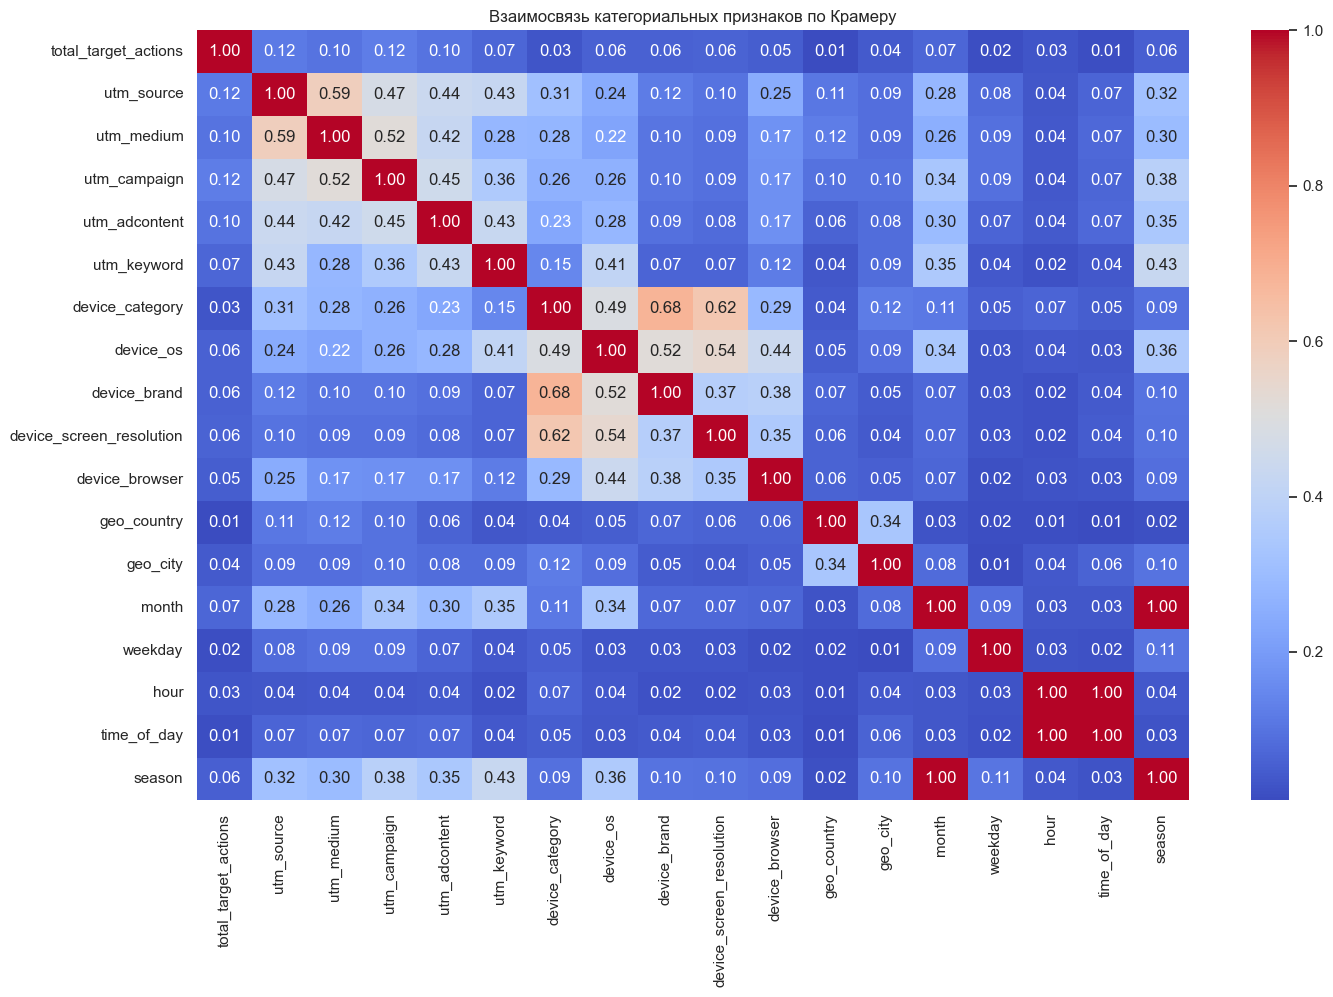

In [97]:
# Выбираем категориальные признаки
cat_columns = ['total_target_actions', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
       'device_os', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'month', 'weekday', 'hour',
       'time_of_day', 'season']

# Строим матрицу Cramér’s V
cramer_matrix = pd.DataFrame(index=cat_columns, columns=cat_columns)

for col1 in cat_columns:
    for col2 in cat_columns:
        cramer_matrix.loc[col1, col2] = cramers_v(df_t[col1], df_t[col2])

cramer_matrix = cramer_matrix.astype(float)

# Визуализируем
plt.figure(figsize=(16, 10))
sns.heatmap(cramer_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Взаимосвязь категориальных признаков по Крамеру")
plt.show()

Анализ важности признаков по модели и матрице Cramér V после подготовки данных к подаче в модель:

- **Маркетинговые признаки** (utm_source, utm_medium, utm_campaign, utm_adcontent, utm_keyword) показали умеренную связь с целевой переменной (Cramér V ~ 0.1–0.4). Это объясняет их значимость при построении модели и важность настройки рекламных кампаний.
- **Технические характеристики устройств** (device_category, device_os, device_brand, device_browser) вносят вклад в предсказание поведения пользователей, что согласуется с наблюдением о преобладании мобильного трафика. Это указывает на необходимость учитывать специфику мобильных пользователей.
- **Временные признаки** (month, season, time_of_day) выделяются как значимые: активность пользователей имеет ярко выраженные сезонные и суточные паттерны (например, декабрь и дневное время). Это даёт основу для усиления рекламы в определённые временные окна.
- **География** (geo_country, geo_city) влияет слабо, за исключением Москвы — основной источник трафика, что подтверждает актуальность локализованных рекламных акций.

Дополнительно:
- Планируется использование stratify=y при разделении выборки, это обосновано значительным дисбалансом классов — целевые действия совершаются крайне редко. Это позволяет сохранить пропорции классов в обучающей и тестовой выборках.

## К модели

In [98]:
from sklearn.model_selection import train_test_split

# Целевая переменная
y = df_t['total_target_actions']
# Признаки
X = df_t.drop('total_target_actions', axis=1)

# Разделим данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### CatBoost

In [99]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool

# Укажем, какие признаки категориальные
cat_features = ['utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
       'device_os', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'month', 'weekday', 'hour',
       'time_of_day', 'season']

# Создадим Pool 
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Инициализация модели с учётом дисбаланса
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    auto_class_weights='Balanced',  # Автоматически балансирует классы
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

# Обучение
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)


0:	test: 0.6822544	best: 0.6822544 (0)	total: 938ms	remaining: 15m 36s
100:	test: 0.7200103	best: 0.7200103 (100)	total: 59.5s	remaining: 8m 49s
200:	test: 0.7251777	best: 0.7251777 (200)	total: 1m 55s	remaining: 7m 38s
300:	test: 0.7279268	best: 0.7279268 (300)	total: 2m 52s	remaining: 6m 39s
400:	test: 0.7300033	best: 0.7300033 (400)	total: 3m 51s	remaining: 5m 46s
500:	test: 0.7312416	best: 0.7312416 (500)	total: 4m 52s	remaining: 4m 51s
600:	test: 0.7320089	best: 0.7320093 (599)	total: 5m 54s	remaining: 3m 55s
700:	test: 0.7325367	best: 0.7325367 (700)	total: 6m 53s	remaining: 2m 56s
800:	test: 0.7329093	best: 0.7329099 (799)	total: 7m 54s	remaining: 1m 57s
900:	test: 0.7332027	best: 0.7332119 (897)	total: 8m 54s	remaining: 58.8s
999:	test: 0.7335312	best: 0.7335312 (999)	total: 9m 55s	remaining: 0us

bestTest = 0.7335311687
bestIteration = 999



In [100]:
# Предсказания
y_pred = cat_model.predict(X_test)
y_pred_proba = cat_model.predict_proba(X_test)[:, 1]

# Метрики
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

ROC-AUC: 0.7335311687245654

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.80    177810
           1       0.16      0.65      0.26     16995

    accuracy                           0.68    194805
   macro avg       0.56      0.67      0.53    194805
weighted avg       0.88      0.68      0.75    194805


Confusion Matrix:
[[121657  56153]
 [  5988  11007]]


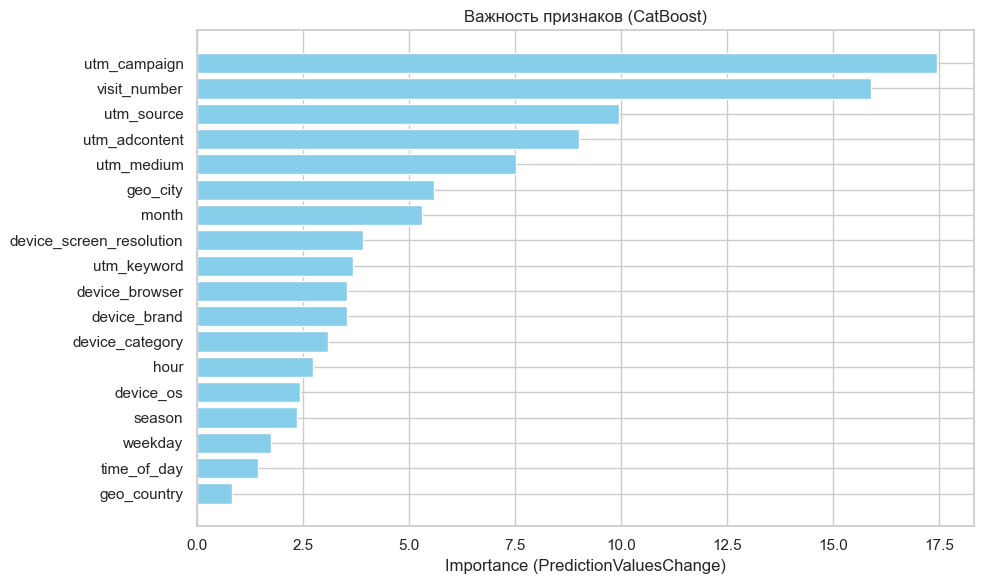

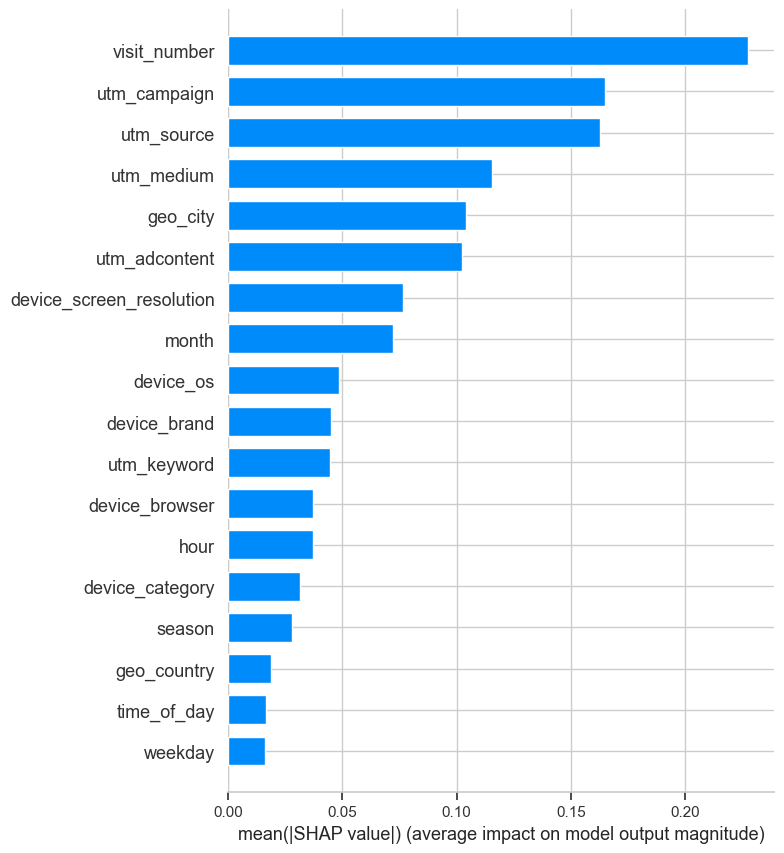

In [101]:
import matplotlib.pyplot as plt

# Получение важности признаков по "PredictionValuesChange"
feature_importance = cat_model.get_feature_importance(prettified=True)

# Отображение топ-20 признаков
top_features = feature_importance.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature Id'], top_features['Importances'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Важность признаков (CatBoost)')
plt.xlabel('Importance (PredictionValuesChange)')
plt.tight_layout()
plt.grid(True)
plt.show()

import shap

# Обёртка для CatBoost
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Сводный график (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

На основе SHAP-диаграммы и таблицы PredictionValuesChange можно сделать следующие наблюдения:

- Наиболее значимый признак — visit_number (количество визитов). Он уверенно занимает первое место по SHAP и второе по PredictionValuesChange, что подтверждает гипотезу: пользователи, возвращающиеся на сайт повторно, значительно более склонны к совершению целевого действия. Это подчёркивает проблему низкой "retention rate".
- Вся группа маркетинговых признаков (utm_campaign, utm_source, utm_medium, utm_adcontent) стабильно входит в топ-5 по обоим методам. Это указывает на высокую зависимость конверсии от качества и структуры рекламного трафика. Причём utm_campaign — лидер по значимости в PredictionValuesChange, что делает его основным рычагом для оптимизации рекламы.
- Признак geo_city занимает высокие позиции (5–6 место), в отличие от geo_country, чья значимость почти нулевая. Это говорит о важности локального таргетинга, особенно с учётом доминирования трафика из Москвы.
- Временные признаки (month, hour, season, time_of_day, weekday) имеют умеренную значимость, что подтверждает ранее замеченные паттерны — всплески активности по дням и в декабре. Особенно выделяются month и hour.
- Технические признаки (device_os, device_brand, device_browser, device_category, device_screen_resolution) показывают разную степень важности, но в целом имеют меньший вклад, чем маркетинговые и поведенческие. Это говорит о том, что тип устройства влияет скорее косвенно.

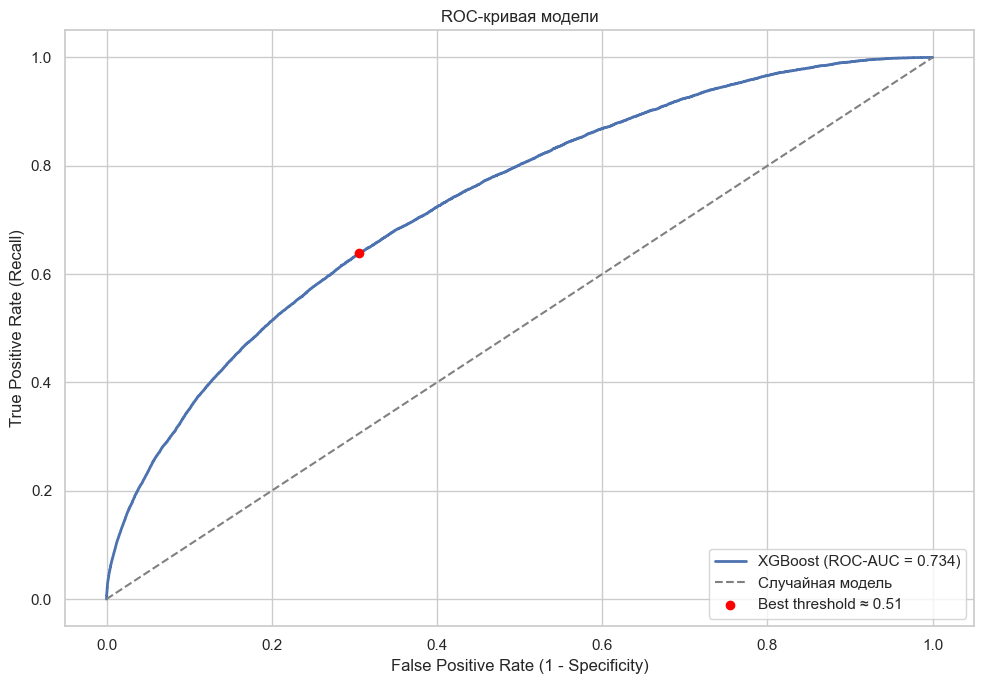

In [102]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Предсказанные вероятности
y_scores = cat_model.predict_proba(X_test)[:, 1]

# ROC-метрики
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Оптимальный порог по Youden's J statistic (максимум tpr - fpr)
youden_index = np.argmax(tpr - fpr)
best_threshold = thresholds[youden_index]
best_fpr = fpr[youden_index]
best_tpr = tpr[youden_index]

# Построение графика
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'XGBoost (ROC-AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Случайная модель')

# Точка наилучшего порога
plt.scatter(best_fpr, best_tpr, color='red', label=f'Best threshold ≈ {best_threshold:.2f}', zorder=5)

# Подписи и оформление
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC-кривая модели')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [103]:
# Предсказанные вероятности для класса 1
y_pred_proba = cat_model.predict_proba(X_test)[:, 1]

# Применяем порог 0.51
threshold = 0.51
y_pred_threshold = (y_pred_proba >= threshold).astype(int)

# Метрики с новым порогом
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))  # ROC-AUC не зависит от порога, можно не менять

print("\nClassification Report:")
print(classification_report(y_test, y_pred_threshold))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_threshold))

ROC-AUC: 0.7335311687245654

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81    177810
           1       0.17      0.63      0.27     16995

    accuracy                           0.69    194805
   macro avg       0.56      0.67      0.54    194805
weighted avg       0.88      0.69      0.76    194805


Confusion Matrix:
[[124655  53155]
 [  6271  10724]]


Вывод по результатам тестирования модели:
- Модель показала ROC-AUC = 0.73, что говорит о умеренно хорошей способности различать классы, особенно с учётом сильного дисбаланса данных.
- Класс 0 (не совершили целевое действие) распознаётся с высокой точностью (precision = 0.95), но recall = 0.70 — то есть модель ошибочно относит к классу 0 значительное число потенциальных клиентов.
- Класс 1 (совершили целевое действие) — выявляется гораздо хуже: низкая точность (precision = 0.17), но относительно высокий recall = 0.63. Это отражает компромисс: модель предпочитает "перестраховаться", метя в 1 всё, что хоть как-то похоже, что логично при борьбе с редкими положительными примерами.
- Макро-усреднённые метрики (особенно f1 = 0.54) подчёркивают перекос в пользу основного класса, несмотря на балансировку весов (auto_class_weights='Balanced') и стратифицированное разделение (stratify=y). Это подтверждает структурные проблемы в самих данных:
- сильный дисбаланс классов (целевые действия редки),
- вероятные шумы или неполнота в признаках (особенно utm_*, device_*, keyword).

Итог: модель справляется с задачей на уровне, приемлемом для начального этапа анализа, выявляя часть целевых пользователей. Однако для повышения точности можно:
- улучшить качество трекинга источников и устройств,
- проработать фиче-инжиниринг,
- использовать ансамбли, фокусированные на recall-positive (например, F2-оптимизированные модели).

In [104]:
# сохраняем обученную модель
cat_model.save_model("catboost_model.cbm")

## Как подать информацию в модель

### 1. Получили строку в виде DF, её будим отправлять в модель для предсказания

In [105]:
# загружаем анализированные данные
df_in = pd.read_csv('ga_sessions.csv', low_memory=False)

In [106]:
# при необходимости можно выбрать интереющую нас строку
df_in_m = df_in[:1]

In [107]:
df_in_m #проверим содержимое

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust


### 2. сначала создаём столбец 'visit_datetime'

In [108]:
df_in_m['visit_datetime'] = pd.to_datetime(df_in_m['visit_date'] + ' ' + df_in_m['visit_time'])

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\3065231956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_m['visit_datetime'] = pd.to_datetime(df_in_m['visit_date'] + ' ' + df_in_m['visit_time'])


In [109]:
df_in_m # убедились что есть

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,visit_datetime
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,2021-11-24 14:36:32


### 3. Генерируем фичи 'month' 'weekday' 'hour' 'time_of_day' 'season'

In [110]:
df_in_m['month'] = df_in_m['visit_datetime'].dt.month
df_in_m['weekday'] = df_in_m['visit_datetime'].dt.dayofweek  # 0 = понедельник
df_in_m['hour'] = df_in_m['visit_datetime'].dt.hour

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\24890021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_m['month'] = df_in_m['visit_datetime'].dt.month
C:\Users\81092\AppData\Local\Temp\ipykernel_24044\24890021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_m['weekday'] = df_in_m['visit_datetime'].dt.dayofweek  # 0 = понедельник
C:\Users\81092\AppData\Local\Temp\ipykernel_24044\24890021.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [111]:
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'утро'
    elif 12 <= hour < 17:
        return 'день'
    elif 17 <= hour < 22:
        return 'вечер'
    else:
        return 'ночь'

df_in_m['time_of_day'] = df_in_m['hour'].apply(get_time_of_day)

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\1436734340.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_m['time_of_day'] = df_in_m['hour'].apply(get_time_of_day)


In [112]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

df_in_m['season'] = df_in_m['month'].apply(get_season)

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\2253345855.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_m['season'] = df_in_m['month'].apply(get_season)


In [113]:
def get_day(weekday):
    if weekday == 0:
        return 'Понедельник'
    elif weekday == 1:
        return 'Вторник'
    elif weekday == 2:
        return 'Среда'
    elif weekday == 3:
        return 'Четверг'
    elif weekday == 4:
        return 'Пятница'
    elif weekday == 5:
        return 'Суббота'
    else:
        return 'Воскресенье'

df_in_m['weekday'] = df_in_m['weekday'].apply(get_day)

C:\Users\81092\AppData\Local\Temp\ipykernel_24044\2805847866.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_m['weekday'] = df_in_m['weekday'].apply(get_day)


In [114]:
df_in_m # убедимся фичи на месте

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,visit_datetime,month,weekday,hour,time_of_day,season
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,2021-11-24 14:36:32,11,Среда,14,день,осень


### 4. Сравним с X и дропаем лишнее

In [115]:
X[:1]

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,month,weekday,hour,time_of_day,season
0,1,BHcvLfOaCWvWTykYqHVe,cpc,unknown,unknown,unknown,mobile,unknown,Meizu,360x720,YaBrowser,Russia,Moscow,10,Суббота,14,день,осень


In [116]:
df_in_m = df_in_m.drop(['session_id', 'client_id', 'device_model', 'visit_date', 'visit_time', 'visit_datetime'], axis=1)

### 5. Всё вроде на месте, но есть нюанс, если модель получит значение фичи, которое она не видела при обучении прилетит ошибка.  
Разберём поэтапно

#### 'visit_number' это числовой признак отправляем его в модель как есть

#### 'utm_source' это категориальный признак, придётся обработать

In [117]:
top_sources # тут спрятан список топ категорий

['ZpYIoDJMcFzVoPFsHGJL',
 'fDLlAcSmythWSCVMvqvL',
 'kjsLglQLzykiRbcDiGcD',
 'bByPQxmDaMXgpHeypKSM',
 'BHcvLfOaCWvWTykYqHVe',
 'MvfHsxITijuriZxsqZqt',
 'aXQzDWsJuGXeBXexNHjc',
 'jaSOmLICuBzCFqHfBdRg',
 'QxAxdyPLuQMEcrdZWdWb',
 'ISrKoXQCxqqYvAZICvjs',
 'hTjLvqNxGggkGnxSCaTm',
 'nSReTmyFtbSjlPrTKoaX',
 'IZEXUFLARCUMynmHNBGo',
 'vFcAhRxLfOWKhvxjELkx',
 'RmEBuqrriAfAVsLQQmhk',
 'KgicpPxiEQfzPlPwQZJq',
 'oZCzWSykfixnjMPDNjSU',
 'iNFgfQPqHPBuvGCYtrQE',
 'DnEUulZAecfGPvdtZBYS',
 'BKeImrJuRDZcHiSSTdzm',
 'eLzNJHzPelJpEyBwMrKo',
 'PlbkrSYoHuZBWfYjYnfw',
 'YlsczTIyBSwTLNtuDkCd',
 'gVRrcxiDQubJiljoTbGm',
 'FTAuYVNoYYxgvKMpKSLW']

In [118]:
#задаём вручную для переноса из ноутбука
top_sources = ['ZpYIoDJMcFzVoPFsHGJL',
 'fDLlAcSmythWSCVMvqvL',
 'kjsLglQLzykiRbcDiGcD',
 'bByPQxmDaMXgpHeypKSM',
 'BHcvLfOaCWvWTykYqHVe',
 'MvfHsxITijuriZxsqZqt',
 'aXQzDWsJuGXeBXexNHjc',
 'jaSOmLICuBzCFqHfBdRg',
 'QxAxdyPLuQMEcrdZWdWb',
 'ISrKoXQCxqqYvAZICvjs',
 'hTjLvqNxGggkGnxSCaTm',
 'nSReTmyFtbSjlPrTKoaX',
 'IZEXUFLARCUMynmHNBGo',
 'vFcAhRxLfOWKhvxjELkx',
 'RmEBuqrriAfAVsLQQmhk',
 'KgicpPxiEQfzPlPwQZJq',
 'oZCzWSykfixnjMPDNjSU',
 'iNFgfQPqHPBuvGCYtrQE',
 'DnEUulZAecfGPvdtZBYS',
 'BKeImrJuRDZcHiSSTdzm',
 'eLzNJHzPelJpEyBwMrKo',
 'PlbkrSYoHuZBWfYjYnfw',
 'YlsczTIyBSwTLNtuDkCd',
 'gVRrcxiDQubJiljoTbGm',
 'FTAuYVNoYYxgvKMpKSLW']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['utm_source'] = df_in_m['utm_source'].apply(lambda x: x if x in top_sources else 'other')

#### 'utm_medium' аналогично

In [119]:
top_medium

['banner',
 '(none)',
 'cpc',
 'referral',
 'cpm',
 'organic',
 'email',
 'push',
 'blogger_channel',
 'smartbanner',
 'cpv',
 'stories',
 'post',
 'tg',
 'smm',
 'blogger_stories',
 'cpa',
 'outlook',
 'clicks',
 'app',
 '(not set)',
 'blogger_header',
 'info_text',
 'landing',
 'sms']

In [120]:
top_medium = ['banner',
 '(none)',
 'cpc',
 'referral',
 'cpm',
 'organic',
 'email',
 'push',
 'blogger_channel',
 'smartbanner',
 'cpv',
 'stories',
 'post',
 'tg',
 'smm',
 'blogger_stories',
 'cpa',
 'outlook',
 'clicks',
 'app',
 '(not set)',
 'blogger_header',
 'info_text',
 'landing',
 'sms']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['utm_medium'] = df_in_m['utm_medium'].apply(lambda x: x if x in top_medium else 'other')

#### 'utm_campaign' аналогично

In [121]:
top_campaign

['LTuZkdKfxRGVceoWkVyg',
 'LEoPHuyFvzoNfnzGgfcd',
 'gecBYcKZCPMcVYdSSzKP',
 'unknown',
 'FTjNLDyTrXaWYgZymFkV',
 'XHNUiSKKGTEpSAlaVMFQ',
 'bxOTvPtyGSdUrbwoXCPO',
 'sbJRYgVfvcnqKJNDDYIr',
 'YCKgTzTDywjcWyQudGch',
 'LwJZxKuWmvOhPsaCeRjG',
 'nSReTmyFtbSjlPrTKoaX',
 'RoDitORHdzGfGhNCyEMy',
 'bJJuEXRheRIxXEaYIXqM',
 'zxoiLxhuSIFrCeTLQVWZ',
 'SgIUDYUKnyWHVowUOqid',
 'jvsVVQVKRfBIqBDBuCkq',
 'MXqmDyetMTICSSitTjWV',
 'JwYIveaHVpeeRZloQCfF',
 'eimRuUrNhZLAYcwRrNXu',
 'hkvDVxqLOzGjGaoNiNzN',
 'jqlUOdZBNZYfInQVcZlS',
 'okTXSMadDkjvntEHzIjp',
 'PXQWdUxeUoXfoKzTBGpY',
 'YDIkQmcjRkpdxGbLLtNN',
 'ESphyUeLTPINiYALHWrO']

In [122]:
top_campaign = ['LTuZkdKfxRGVceoWkVyg',
 'LEoPHuyFvzoNfnzGgfcd',
 'gecBYcKZCPMcVYdSSzKP',
 'unknown',
 'FTjNLDyTrXaWYgZymFkV',
 'XHNUiSKKGTEpSAlaVMFQ',
 'bxOTvPtyGSdUrbwoXCPO',
 'sbJRYgVfvcnqKJNDDYIr',
 'YCKgTzTDywjcWyQudGch',
 'LwJZxKuWmvOhPsaCeRjG',
 'nSReTmyFtbSjlPrTKoaX',
 'RoDitORHdzGfGhNCyEMy',
 'bJJuEXRheRIxXEaYIXqM',
 'zxoiLxhuSIFrCeTLQVWZ',
 'SgIUDYUKnyWHVowUOqid',
 'jvsVVQVKRfBIqBDBuCkq',
 'MXqmDyetMTICSSitTjWV',
 'JwYIveaHVpeeRZloQCfF',
 'eimRuUrNhZLAYcwRrNXu',
 'hkvDVxqLOzGjGaoNiNzN',
 'jqlUOdZBNZYfInQVcZlS',
 'okTXSMadDkjvntEHzIjp',
 'PXQWdUxeUoXfoKzTBGpY',
 'YDIkQmcjRkpdxGbLLtNN',
 'ESphyUeLTPINiYALHWrO']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['utm_campaign'] = df_in_m['utm_campaign'].apply(lambda x: x if x in top_campaign else 'other')

#### 'utm_adcontent' аналогично

In [123]:
top_adcontent

['JNHcPlZPxEMWDnRiyoBf',
 'unknown',
 'vCIpmpaGBnIQhyYNkXqp',
 'xhoenQgDQsgfEPYNPwKO',
 'PkybGvWbaqORmxjNunqZ',
 'nNqUcgFgcqQbTVSvgaHr',
 'XSkXBCPfnJjvxbfeewtd',
 'LLfCasrxQzJIyuldcuWy',
 'guyNoEvzgofQvvwExGOq',
 'SOkCdPxfUcZUzzOdgGES',
 'AdeErYgVTbRcAWtHrMHq',
 'SAVVWaMghGnnvPOqMOIt',
 'sYzBROYhjSDbFZCpzGyf',
 'qhEmhjPXvwgEHdBikgEQ',
 'WAeycgIqKXoOMXPzDUDX',
 'dUuXlWzvmhDSyclWRhNP',
 'FkiRXDLOWtzVfvhEkhNo',
 'EteMoEECGsaJeMnuvAZD',
 'eEkLatVAYTkibdzPIyDi',
 'WYLajZgbUhGimwBKDZUH',
 'ZKlsrASsGaoEHfwkdKjL',
 'aYAcKhelKzYpXrRYknSP',
 'DZYjhfIUfdqhfuTNUmjn',
 'IwBedorwDIzxDRIZUTNo',
 'vilbbyUvEWbiJvxXpaNN']

In [124]:
top_adcontent = ['JNHcPlZPxEMWDnRiyoBf',
 'unknown',
 'vCIpmpaGBnIQhyYNkXqp',
 'xhoenQgDQsgfEPYNPwKO',
 'PkybGvWbaqORmxjNunqZ',
 'nNqUcgFgcqQbTVSvgaHr',
 'XSkXBCPfnJjvxbfeewtd',
 'LLfCasrxQzJIyuldcuWy',
 'guyNoEvzgofQvvwExGOq',
 'SOkCdPxfUcZUzzOdgGES',
 'AdeErYgVTbRcAWtHrMHq',
 'SAVVWaMghGnnvPOqMOIt',
 'sYzBROYhjSDbFZCpzGyf',
 'qhEmhjPXvwgEHdBikgEQ',
 'WAeycgIqKXoOMXPzDUDX',
 'dUuXlWzvmhDSyclWRhNP',
 'FkiRXDLOWtzVfvhEkhNo',
 'EteMoEECGsaJeMnuvAZD',
 'eEkLatVAYTkibdzPIyDi',
 'WYLajZgbUhGimwBKDZUH',
 'ZKlsrASsGaoEHfwkdKjL',
 'aYAcKhelKzYpXrRYknSP',
 'DZYjhfIUfdqhfuTNUmjn',
 'IwBedorwDIzxDRIZUTNo',
 'vilbbyUvEWbiJvxXpaNN']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['utm_adcontent'] = df_in_m['utm_adcontent'].apply(lambda x: x if x in top_adcontent else 'other')

#### 'utm_keyword' аналогично

In [125]:
top_utm_keyword

['unknown',
 'puhZPIYqKXeFPaUviSjo',
 'ITfrGJNwVsHBGJMAKoct',
 'UKNBOHebRIIsQRsjNKay',
 'JajANoFxoqXfKRNBUhzx',
 'hAmNSZmQkKQKAjZEGlgb',
 'aXQzDWsJuGXeBXexNHjc',
 'ZNhSIPchlbnKwZWcsKzz',
 'RkpOyeEPgcMBSDuHLQcj',
 'XEayFbemrPYbxFeNbxif',
 'pHqgLcdBQPSLcrTpLkdr',
 'IGUCNvHlhfHpROGclCit',
 'tVtbIKrPSOvrXLCznVVe',
 'BmOOOIoWGHEfxEfoUezs',
 'pucKZkLDtpMDBTobJAJG']

In [126]:
top_utm_keyword = ['unknown',
 'puhZPIYqKXeFPaUviSjo',
 'ITfrGJNwVsHBGJMAKoct',
 'UKNBOHebRIIsQRsjNKay',
 'JajANoFxoqXfKRNBUhzx',
 'hAmNSZmQkKQKAjZEGlgb',
 'aXQzDWsJuGXeBXexNHjc',
 'ZNhSIPchlbnKwZWcsKzz',
 'RkpOyeEPgcMBSDuHLQcj',
 'XEayFbemrPYbxFeNbxif',
 'pHqgLcdBQPSLcrTpLkdr',
 'IGUCNvHlhfHpROGclCit',
 'tVtbIKrPSOvrXLCznVVe',
 'BmOOOIoWGHEfxEfoUezs',
 'pucKZkLDtpMDBTobJAJG']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['utm_keyword'] = df_in_m['utm_keyword'].apply(lambda x: x if x in top_utm_keyword else 'other')

#### 'device_category' у нас их всего 3, но если прибавится надо подстраховаться

In [127]:
df_t['device_category'].unique()

['mobile', 'desktop', 'tablet']
Categories (3, object): ['desktop', 'mobile', 'tablet']

In [128]:
top_device_category = ['desktop', 'mobile', 'tablet']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['device_category'] = df_in_m['device_category'].apply(lambda x: x if x in top_device_category else 'other')

#### 'device_os' аналогично как с utm

In [129]:
top_device_os

['unknown', 'iOS', 'Android', 'Windows', 'Macintosh']

In [130]:
top_device_os = ['unknown', 'iOS', 'Android', 'Windows', 'Macintosh']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['device_os'] = df_in_m['device_os'].apply(lambda x: x if x in top_device_os else 'other')

#### 'device_brand' аналогично

In [131]:
top_device_brand

['Apple',
 'Samsung',
 'unknown',
 'Xiaomi',
 'Huawei',
 'Realme',
 '(not set)',
 'OPPO',
 'Vivo',
 'OnePlus',
 'Asus',
 'Nokia',
 'Sony',
 'ZTE',
 'Google',
 'Meizu',
 'Blackview',
 'Lenovo',
 'Motorola',
 'Tecno']

In [132]:
top_device_brand = ['Apple',
 'Samsung',
 'unknown',
 'Xiaomi',
 'Huawei',
 'Realme',
 '(not set)',
 'OPPO',
 'Vivo',
 'OnePlus',
 'Asus',
 'Nokia',
 'Sony',
 'ZTE',
 'Google',
 'Meizu',
 'Blackview',
 'Lenovo',
 'Motorola',
 'Tecno']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['device_brand'] = df_in_m['device_brand'].apply(lambda x: x if x in top_device_brand else 'other')

#### 'device_screen_resolution' аналогично

In [133]:
top_device_screen_resolution

['414x896',
 '375x812',
 '1920x1080',
 '393x851',
 '375x667',
 '360x780',
 '412x915',
 '360x800',
 '390x844',
 '360x640',
 '393x873',
 '412x892',
 '360x760',
 '1440x900',
 '428x926',
 '360x720',
 '1536x864',
 '1366x768',
 '414x736',
 '412x846',
 '1280x720',
 '412x869',
 '320x568',
 '360x740',
 '385x854']

In [134]:
top_device_screen_resolution = ['414x896',
 '375x812',
 '1920x1080',
 '393x851',
 '375x667',
 '360x780',
 '412x915',
 '360x800',
 '390x844',
 '360x640',
 '393x873',
 '412x892',
 '360x760',
 '1440x900',
 '428x926',
 '360x720',
 '1536x864',
 '1366x768',
 '414x736',
 '412x846',
 '1280x720',
 '412x869',
 '320x568',
 '360x740',
 '385x854']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['device_screen_resolution'] = df_in_m['device_screen_resolution'].apply(lambda x: x if x in top_device_screen_resolution else 'other')

#### 'device_browser' аналогично

In [135]:
top_device_browser

['Chrome',
 'Safari',
 'YaBrowser',
 'Android Webview',
 'Samsung Internet',
 'Firefox',
 'Opera',
 'Edge']

In [136]:
top_device_browser = ['Chrome',
 'Safari',
 'YaBrowser',
 'Android Webview',
 'Samsung Internet',
 'Firefox',
 'Opera',
 'Edge']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['device_browser'] = df_in_m['device_browser'].apply(lambda x: x if x in top_device_browser else 'other')

#### 'geo_country' аналогично

In [137]:
top_geo_country

['Russia']

In [138]:
top_geo_country = ['Russia']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['geo_country'] = df_in_m['geo_country'].apply(lambda x: x if x in top_geo_country else 'other')

#### 'geo_city' аналогично

In [139]:
top_geo_city

['Moscow',
 'Saint Petersburg',
 '(not set)',
 'Yekaterinburg',
 'Krasnodar',
 'Kazan',
 'Samara',
 'Ufa',
 'Novosibirsk',
 'Nizhny Novgorod',
 'Chelyabinsk',
 'Rostov-on-Don',
 'Krasnoyarsk',
 'Grozny',
 'Irkutsk',
 'Tula',
 'Balashikha',
 'Vladivostok',
 'Sochi',
 'Voronezh',
 'Yaroslavl',
 'Khimki',
 'Perm',
 'Tyumen',
 'Saratov']

In [140]:
top_geo_city = ['Moscow',
 'Saint Petersburg',
 '(not set)',
 'Yekaterinburg',
 'Krasnodar',
 'Kazan',
 'Samara',
 'Ufa',
 'Novosibirsk',
 'Nizhny Novgorod',
 'Chelyabinsk',
 'Rostov-on-Don',
 'Krasnoyarsk',
 'Grozny',
 'Irkutsk',
 'Tula',
 'Balashikha',
 'Vladivostok',
 'Sochi',
 'Voronezh',
 'Yaroslavl',
 'Khimki',
 'Perm',
 'Tyumen',
 'Saratov']

# Применяем логику: если значение в топ, то x, иначе 'other'
df_in_m['geo_city'] = df_in_m['geo_city'].apply(lambda x: x if x in top_geo_city else 'other')

#### 'month' 'weekday' 'hour' 'time_of_day' 'season' а вот месяцев, дней недели, часов, разделением дня и сезонов врятлит прибавиться. Оставляем как есть 

### 6. Вроде всё да не всё. проверим тип данных в получившейся таблице

In [141]:
df_in_m.columns

Index(['visit_number', 'utm_source', 'utm_medium', 'utm_campaign',
       'utm_adcontent', 'utm_keyword', 'device_category', 'device_os',
       'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'month', 'weekday', 'hour', 'time_of_day',
       'season'],
      dtype='object')

In [142]:
df_in_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   visit_number              1 non-null      int64 
 1   utm_source                1 non-null      object
 2   utm_medium                1 non-null      object
 3   utm_campaign              1 non-null      object
 4   utm_adcontent             1 non-null      object
 5   utm_keyword               1 non-null      object
 6   device_category           1 non-null      object
 7   device_os                 1 non-null      object
 8   device_brand              1 non-null      object
 9   device_screen_resolution  1 non-null      object
 10  device_browser            1 non-null      object
 11  geo_country               1 non-null      object
 12  geo_city                  1 non-null      object
 13  month                     1 non-null      int32 
 14  weekday                   1 no

In [143]:
# заметим что у нас категориальные фичи не имеют тип category и надо их привести к этому типу
cols_cat = ['utm_source', 'utm_medium', 'utm_campaign',
       'utm_adcontent', 'utm_keyword', 'device_category', 'device_os',
       'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'month', 'weekday', 'hour', 'time_of_day',
       'season']

for col in cols_cat:
    df_in_m[col] = df_in_m[col].astype('category')

In [144]:
df_in_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   visit_number              1 non-null      int64   
 1   utm_source                1 non-null      category
 2   utm_medium                1 non-null      category
 3   utm_campaign              1 non-null      category
 4   utm_adcontent             1 non-null      category
 5   utm_keyword               1 non-null      category
 6   device_category           1 non-null      category
 7   device_os                 1 non-null      category
 8   device_brand              1 non-null      category
 9   device_screen_resolution  1 non-null      category
 10  device_browser            1 non-null      category
 11  geo_country               1 non-null      category
 12  geo_city                  1 non-null      category
 13  month                     1 non-null      category
 14

### наш X готов делаем предсказание класса 1

In [145]:
# загружаем обученную модель CatBoost
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier()
cat_model.load_model("catboost_model.cbm")

In [146]:
y_pred_positive = cat_model.predict_proba(df_in_m)[:, 1]

# Применяем порог 0.51
threshold = 0.51

y_pred = (y_pred_positive >= 0.5).astype(int)
y_pred

array([0])

Поздравляю вы получили предсказание